### Modules

In [38]:
# general 
import psycopg2 as psyc
import pandas as pd
import numpy as np
import json
import datetime
from collections import Counter
from pprint import pprint

# statistics 
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import ttest_rel, bartlett, levene

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### ETL

In [2]:
# saved database connection data as a hidden json file, for confidentiality 
with open("/Users/lucasramadan/SCL-Work/.db_conn.json", 'r') as f:
    db_conn = json.load(f)

In [3]:
# create the connection
# unpacking the arguments
conn = psyc.connect(**db_conn)

In [4]:
cur = conn.cursor()

In [5]:
# query to gather metrics 
with open('/Users/lucasramadan/SCL-Work/Pickup_Logic_Change_Test/travel_time_arrays.sql') as f:
    q = f.read()

In [74]:
cur.execute(q)

In [75]:
data = cur.fetchall()

In [76]:
data = np.asarray(data)

In [77]:
data[0]

array([datetime.date(2016, 11, 4), '1-BAY',
       [42.3291666666667, 29.2, 56.65, 5.22666668494542, 11.5308333317439, 31.35, 51.7833333333333, 56.0708333333333, 17.0983333508174, 24.5783333500226, 65.7833333333333, 61.1833333333333, 18.2441666841507, 27.4400000015895, 73.6, 34.9191666682561, 24.3091666658719, 19.05, 65.7833333333333, 60.0, 47.2591666658719],
       [28.0349999984105, 63.7349999984105, 36.6483333349228, 41.0, 5.14166666666667, 29.7066666682561, 18.6, 70.9316666682561, 6.11916666825612, 19.1241666674614, 14.2650000015895, 19.4166666666667, 7.07000000079473, 25.4566666682561, 35.4866666674614, 17.4008333325386, 5.14166666666667, 59.0, 24.1391666650772, 52.5166666666667, 52.5433333317439],
       [9.34499999947018, 12.7469999996821, 18.3241666674614, 20.5, 1.71388888888889, 9.90222222275204, 9.3, 23.6438888894187, 6.11916666825612, 9.5620833337307, 3.56625000039736, 9.70833333333333, 7.07000000079473, 8.48555555608537, 17.7433333337307, 5.80027777751287, 5.14166666666667,

In [78]:
cols = ['market','vtt', 'ptt', 'pttpv', 'ttt']
cols

['market', 'vtt', 'ptt', 'pttpv', 'ttt']

In [80]:
df = pd.DataFrame(data[:, 1:], index=data[:, 0], columns=cols)
df.head()

,market,vtt,ptt,pttpv,ttt
2016-11-04,1-BAY,"[42.3291666667, 29.2, 56.65, 5.22666668495, 11...","[28.0349999984, 63.7349999984, 36.6483333349, ...","[9.34499999947, 12.7469999997, 18.3241666675, ...","[51.6741666661, 41.9469999997, 74.9741666675, ..."
2016-11-04,2-NY,"[28.2875, 35.4366666675, 26.2366666675, 47.716...","[5.0, 38.1775000016, 38.1775000016, 16.0, 45.0...","[0.25, 12.7258333339, 12.7258333339, 8.0, 4.5,...","[28.5375, 48.1625000013, 38.9625000013, 55.716..."
2016-11-04,4-LA,"[5.0, 33.5458333333, 49.2, 85.9333333333, 18.8...","[40.7283333341, 30.8541666667, 42.6833333333, ...","[40.7283333341, 10.2847222222, 21.3416666667, ...","[45.7283333341, 43.8305555556, 70.5416666667, ..."
2016-11-04,5-CHI,"[55.0333333333, 50.6666666667, 35.475, 29.8333...","[45.0, 63.3666666667, 5.63250000079, 45.0, 38....","[22.5, 15.8416666667, 1.12650000016, 45.0, 19....","[77.5333333333, 66.5083333333, 36.6015000002, ..."
2016-11-04,6-DAL,"[18.0041666667, 40.8266666651, 50.4741666675, ...","[29.4933333317, 41.9741666675, 58.6625, 29.0, ...","[9.83111111058, 10.4935416669, 58.6625, 29.0, ...","[27.8352777772, 51.3202083319, 109.136666667, ..."


### Filtering and Segmentation

In [18]:
logic_change_date = datetime.date(2016, 11, 18)

In [19]:
markets = sorted(list(set(df['market'].values)))
markets

['1-BAY', '2-NY', '4-LA', '5-CHI', '6-DAL', '7-HOU', '8-ATL', '9-MIA']

In [81]:
df = df[df.index < datetime.date.today()]

In [82]:
# making a lookup table for adding to later
location_dfs = {market: {'data': df[df['market'] == market]} for market in markets}

In [44]:
# take a look at one of the market level dfs
location_dfs['1-BAY']['data'].head()

,market,vtt,ptt,pttvp,ttt
2016-11-04,1-BAY,"[42.3291666667, 29.2, 56.65, 5.22666668495, 11...","[28.0349999984, 63.7349999984, 36.6483333349, ...","[9.34499999947, 12.7469999997, 18.3241666675, ...","[51.6741666661, 41.9469999997, 74.9741666675, ..."
2016-11-05,1-BAY,"[60.0, 60.0, 12.5650000016, 12.5650000016, 31....","[45.0, 52.5433333317, 21.9008333325, 35.146666...","[22.5, 5.25433333317, 1.36880208328, 2.7035897...","[82.5, 65.2543333332, 13.9338020849, 15.268589..."
2016-11-06,1-BAY,"[22.0, 37.0591666818, 17.8066666842, 17.126666...","[5.14166666667, 5.05666666826, 31.3216666659, ...","[2.57083333333, 1.01133333365, 7.83041666647, ...","[24.5708333333, 38.0705000154, 25.6370833506, ..."
2016-11-07,1-BAY,"[21.5666666667, 16.1, 29.5083333333, 39.916666...","[43.4483333508, 5.0, 30.0, 26.9583333333, 5.0,...","[21.7241666754, 1.0, 15.0, 5.39166666667, 2.5,...","[43.2908333421, 17.1, 44.5083333333, 45.308333..."
2016-11-08,1-BAY,"[16.5741666675, 56.0333333333, 29.6833333333, ...","[5.07083333333, 22.8216666659, 35.1608333349, ...","[5.07083333333, 22.8216666659, 5.0229761907, 0...","[21.6450000008, 78.8549999992, 34.706309524, 3..."


In [45]:
for market in markets:
    daily = location_dfs[market]['data'].copy()
    daily.drop(['market'], axis=1, inplace=True)
    daily = daily.applymap(np.mean)
    location_dfs[market]['daily'] = daily

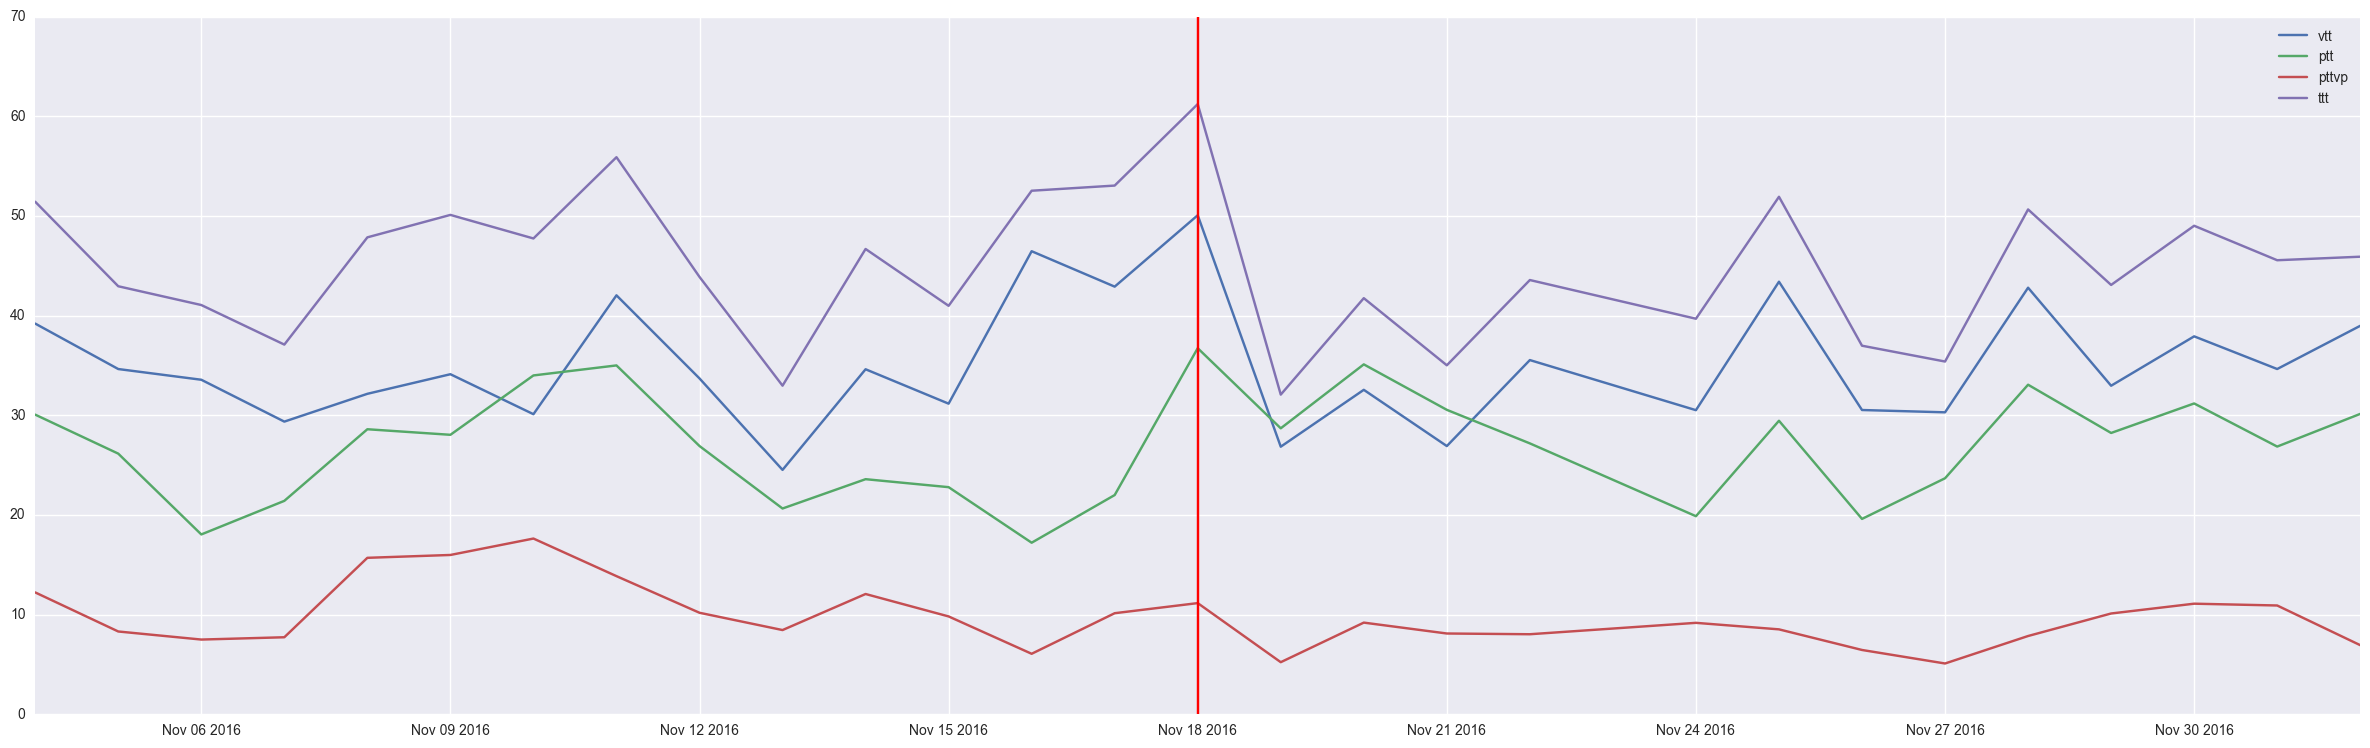

In [27]:
location_dfs['1-BAY']['daily'].plot(figsize=(30, 9))
plt.axvline(logic_change_date, c='r')

### Statistical Analysis

In [125]:
logic_change_date

datetime.date(2016, 11, 18)

In [83]:
for market in location_dfs:
    location_dfs[market]['before'] = {}
    location_dfs[market]['after'] = {}

In [84]:
# calculate before/after data split

for market in location_dfs:
    before_data = location_dfs[market]['data'][location_dfs[market]['data'].index < logic_change_date]
    before_data.drop('market', axis=1, inplace=True)
    location_dfs[market]['before']['data'] = before_data
    
    # after
    after_data = location_dfs[market]['data'][location_dfs[market]['data'].index > logic_change_date]
    after_data.drop('market', axis=1, inplace=True)
    location_dfs[market]['after']['data'] = after_data

/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [85]:
for market in location_dfs:
    for ts in ['before', 'after']:
        for metric in location_dfs[market][ts]['data']:
            d = reduce(lambda x,y: x+y, location_dfs[market][ts]['data'][metric].values)
            location_dfs[market][ts][metric] = d

In [62]:
location_dfs['1-BAY'].keys()

['after', 'data', 'daily', 'before']

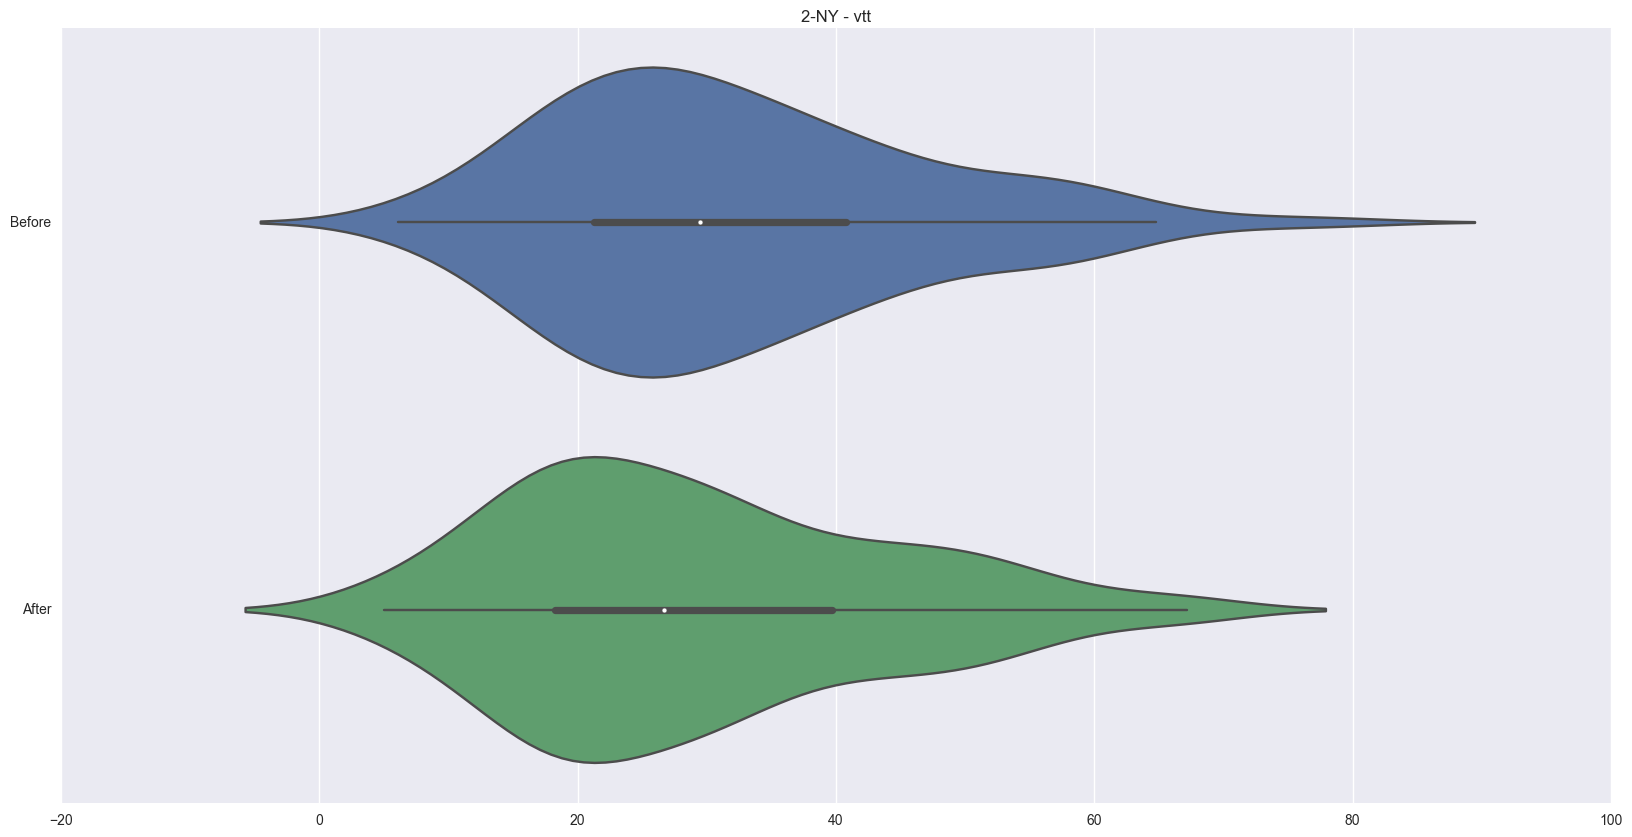

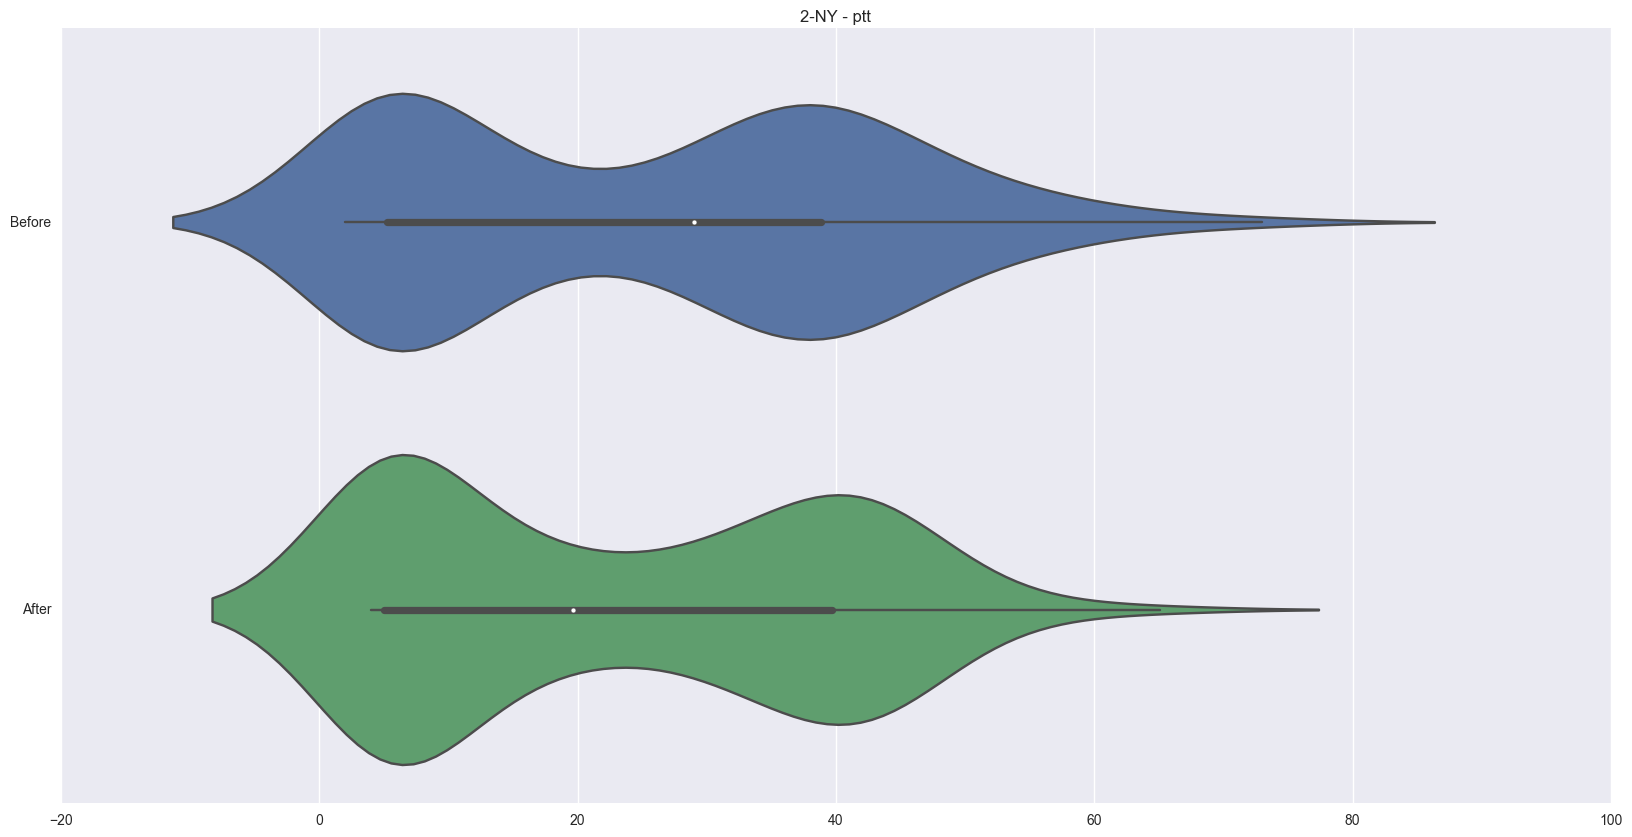

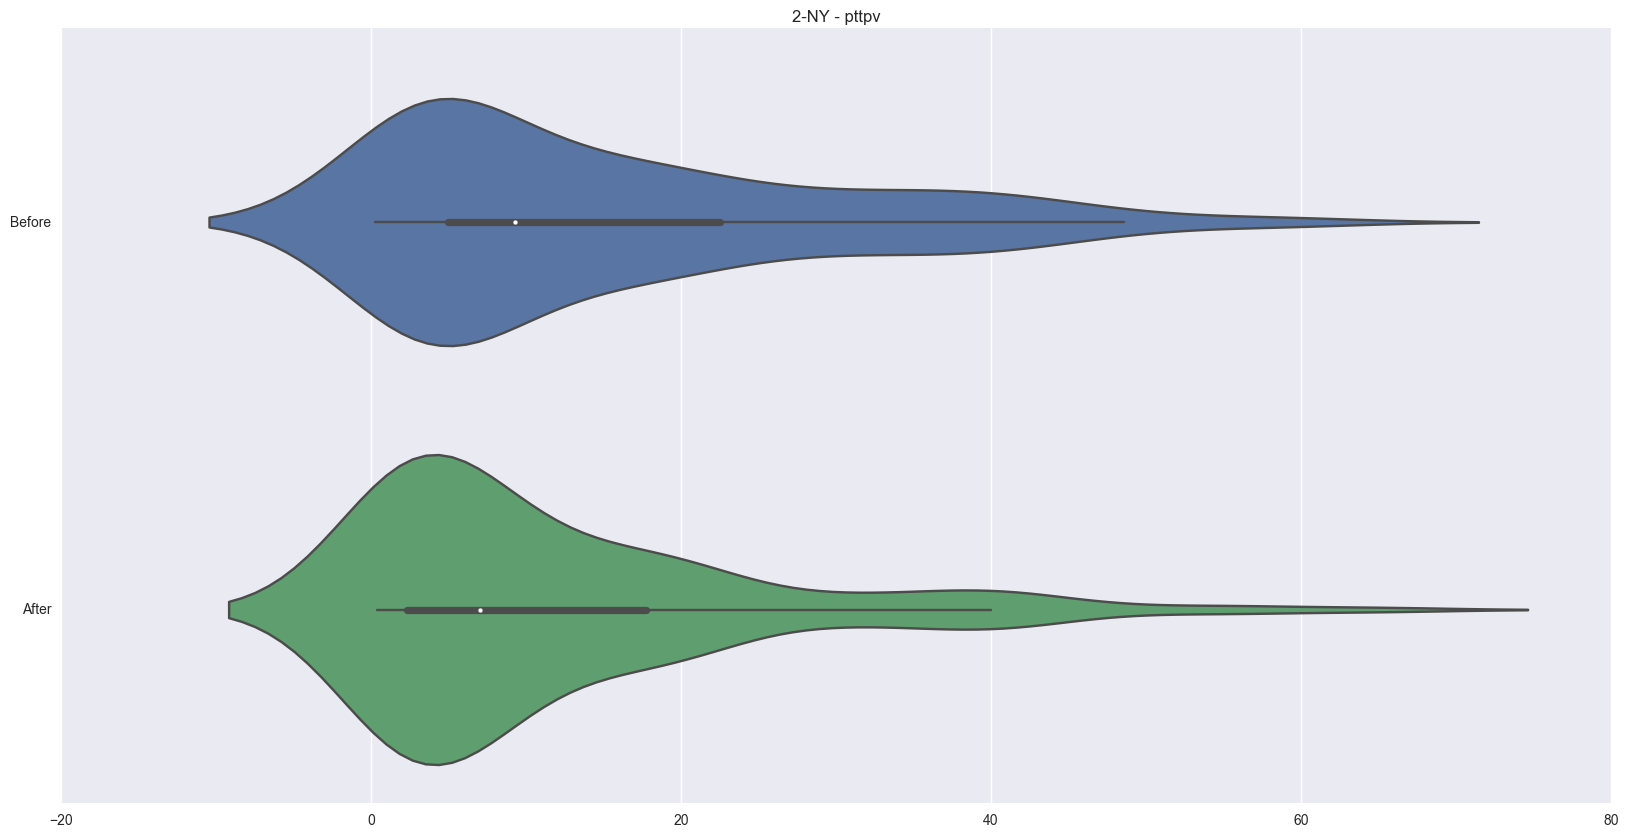

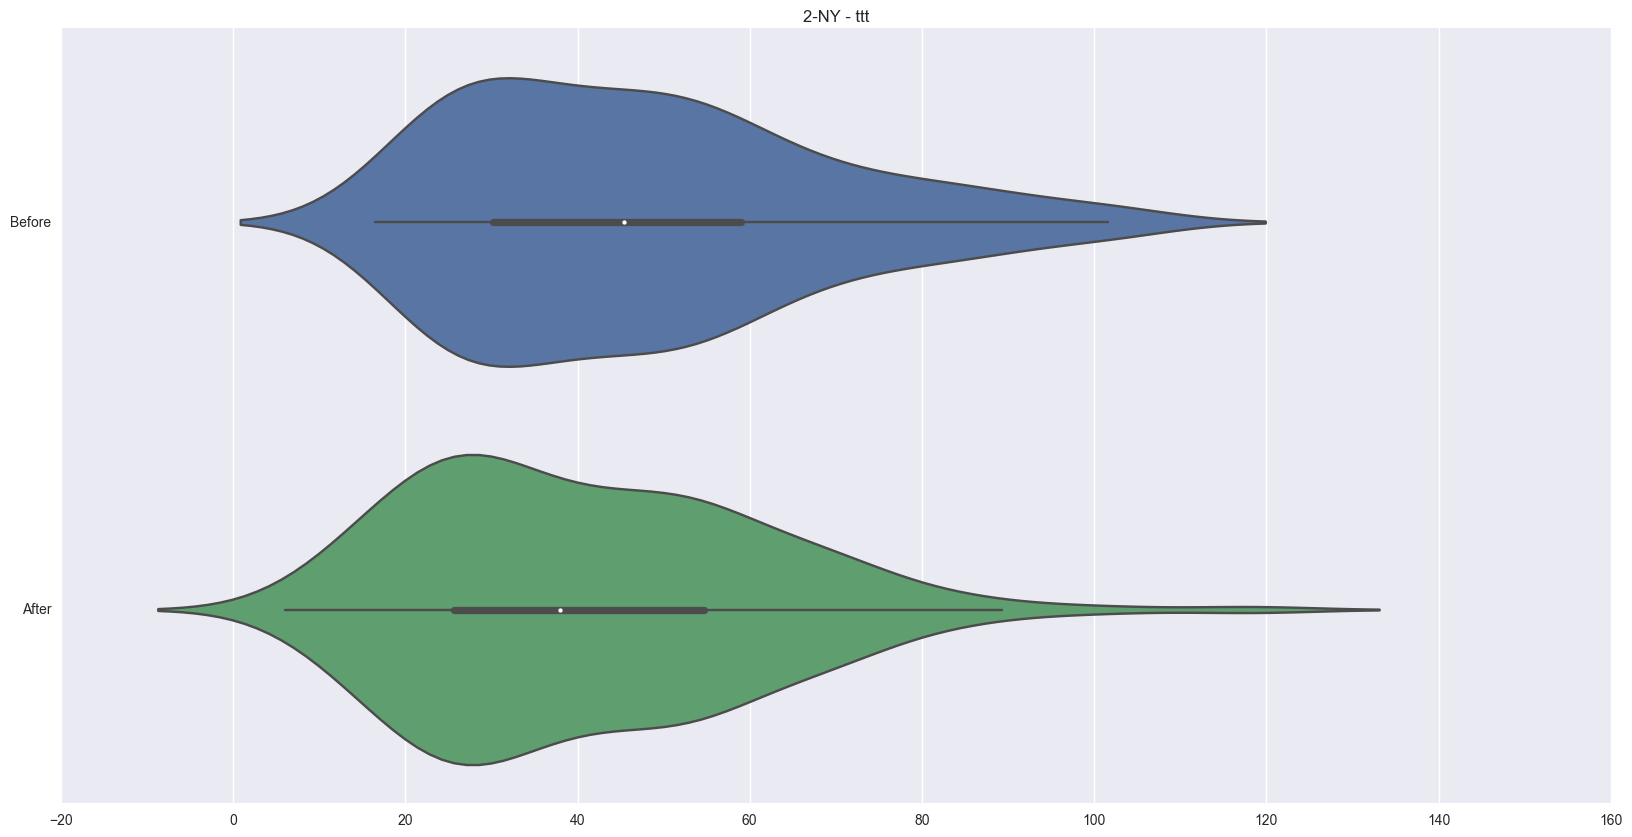

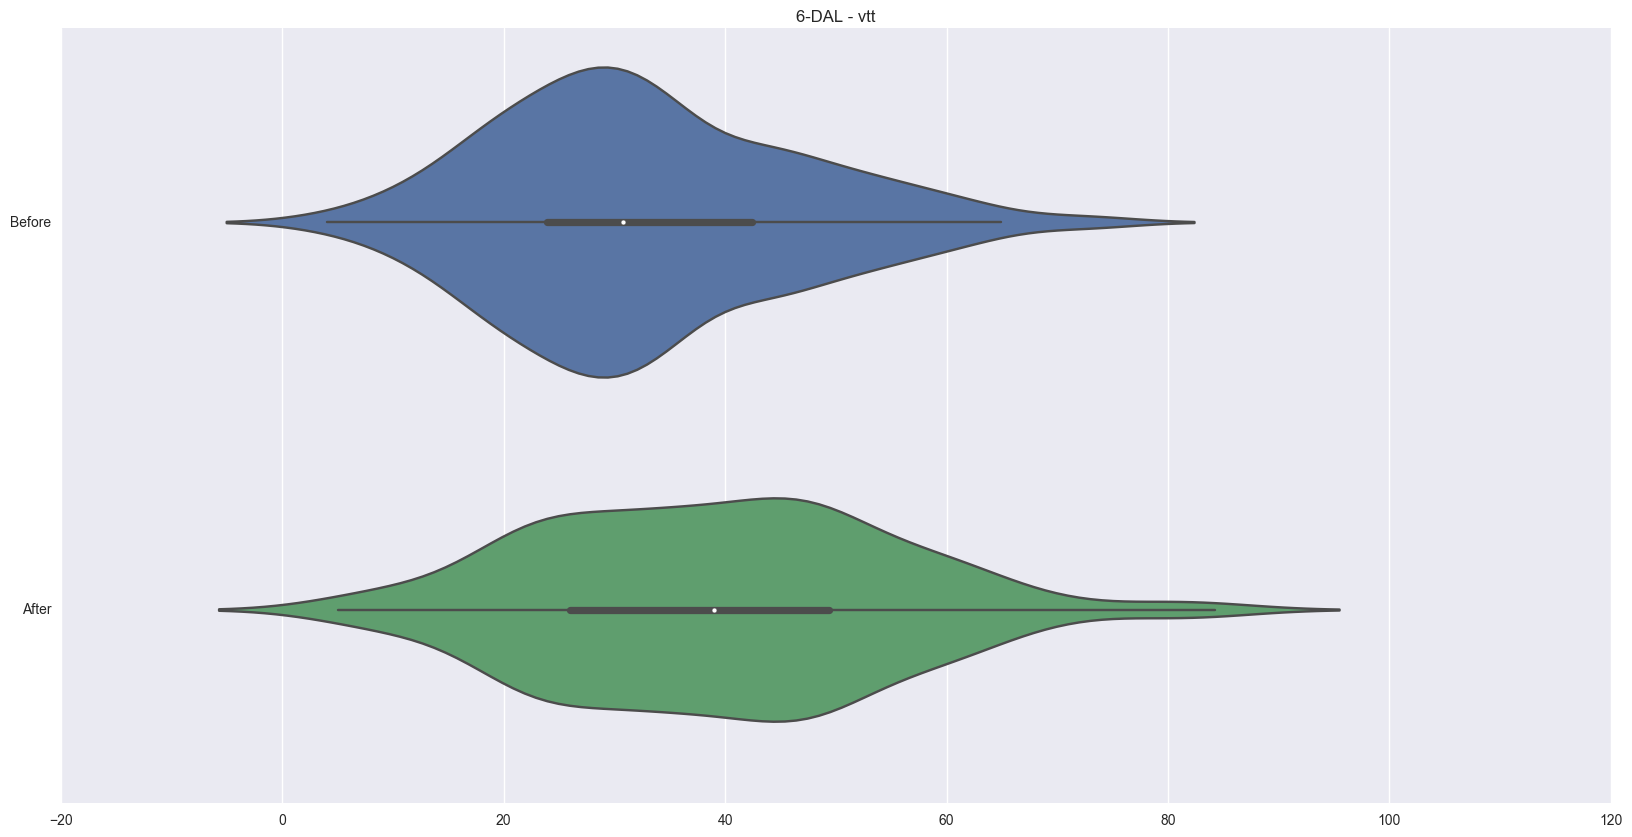

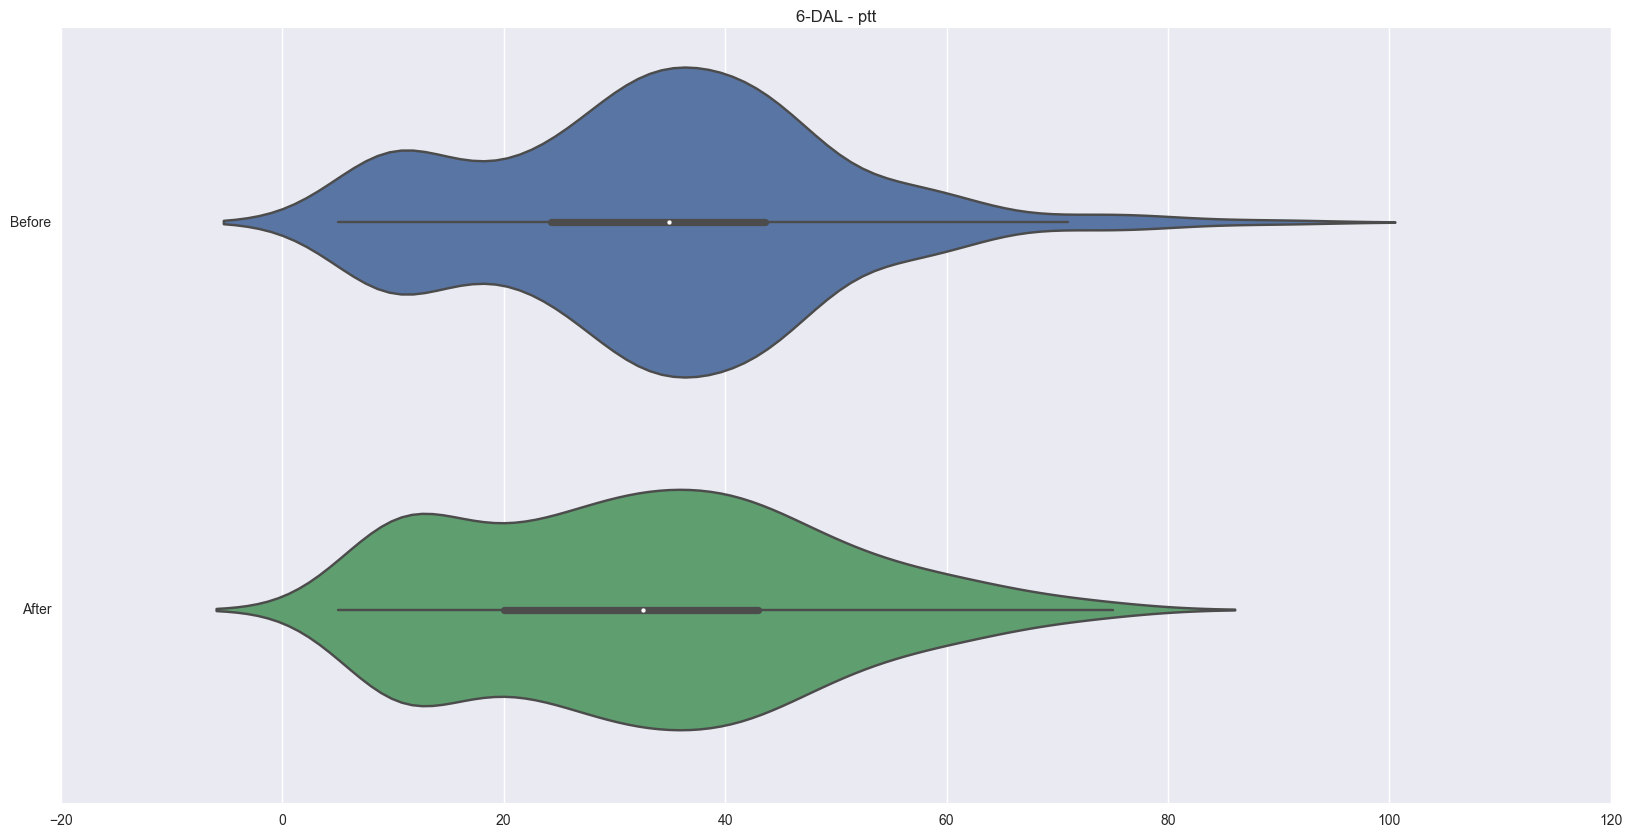

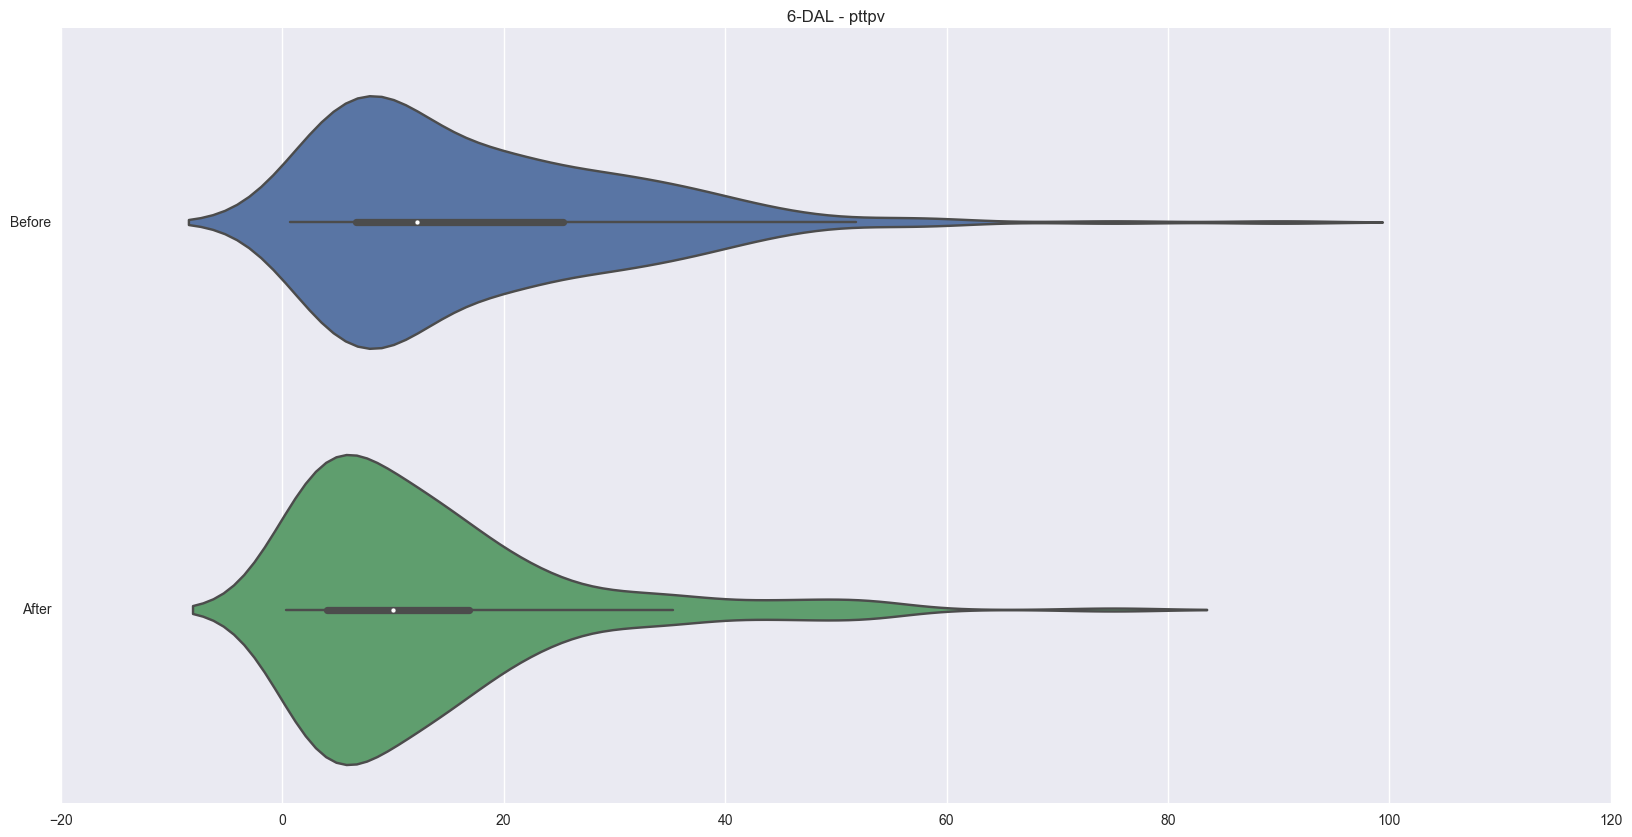

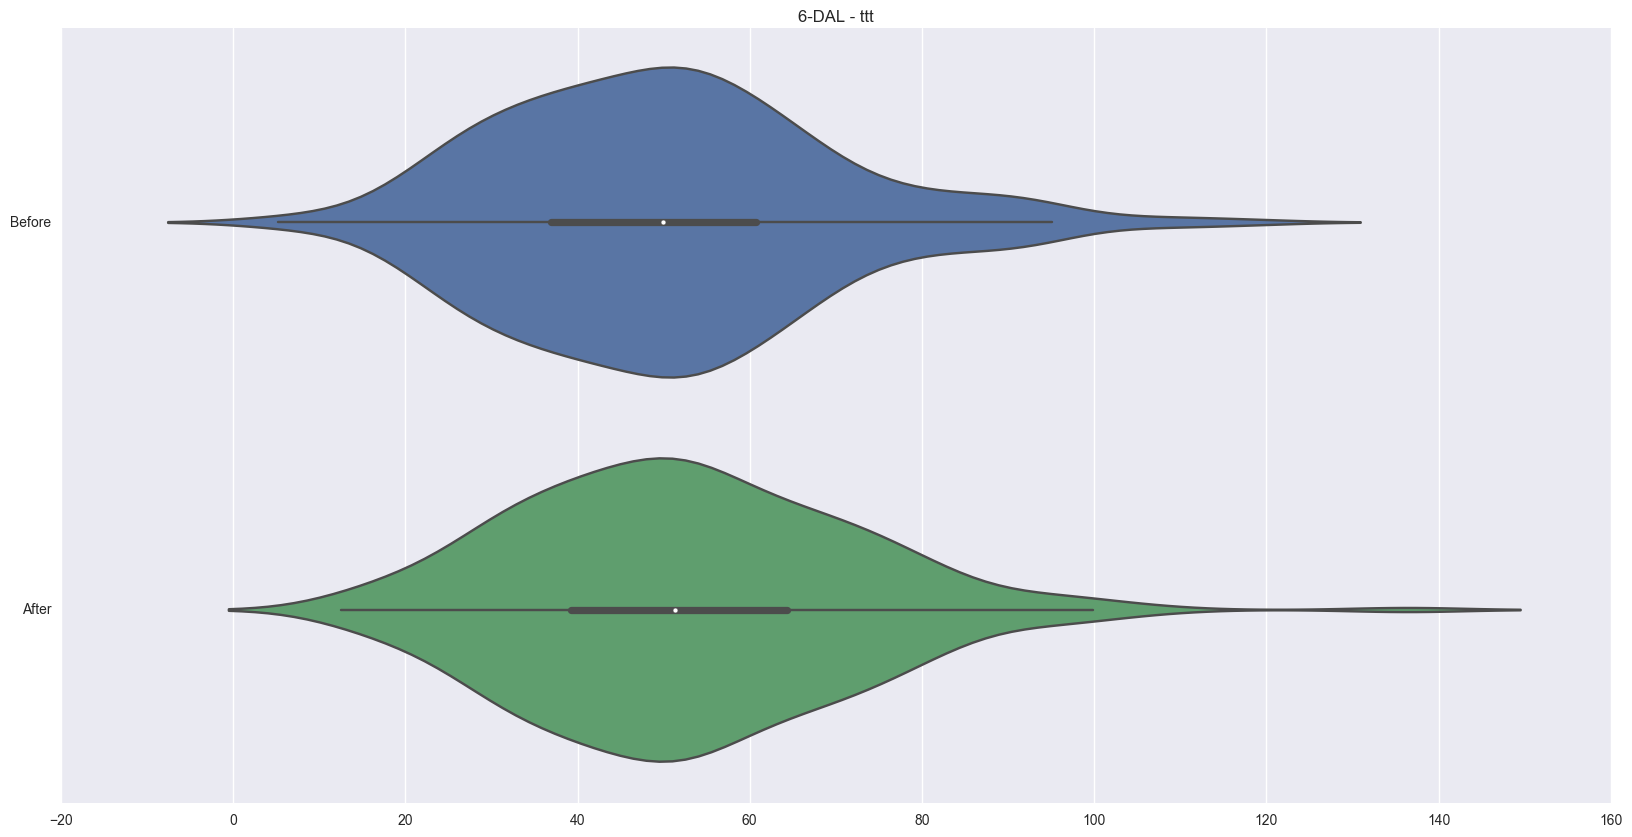

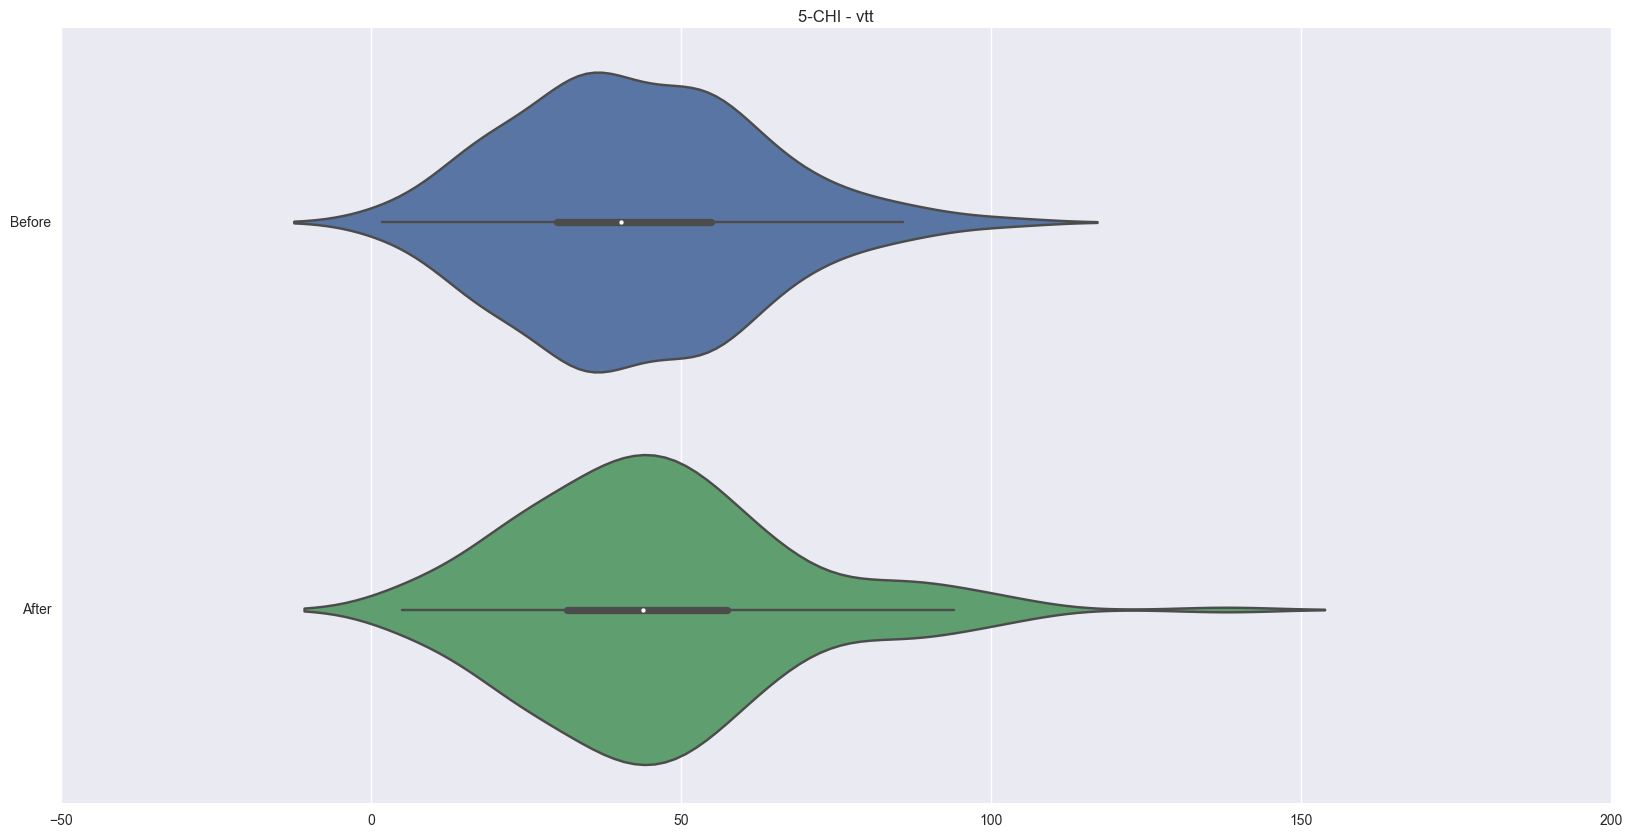

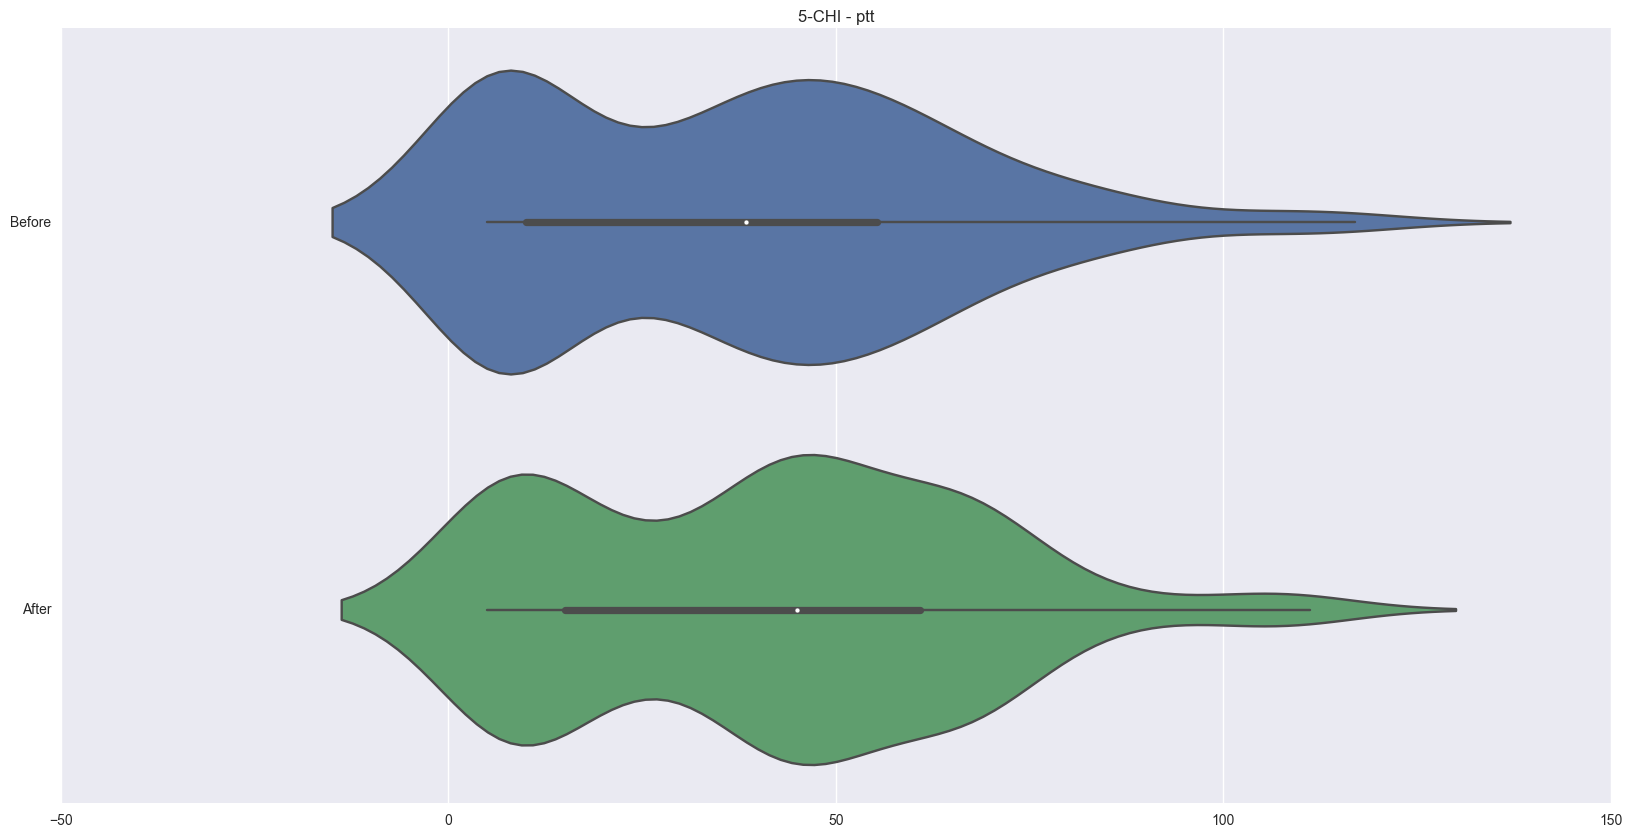

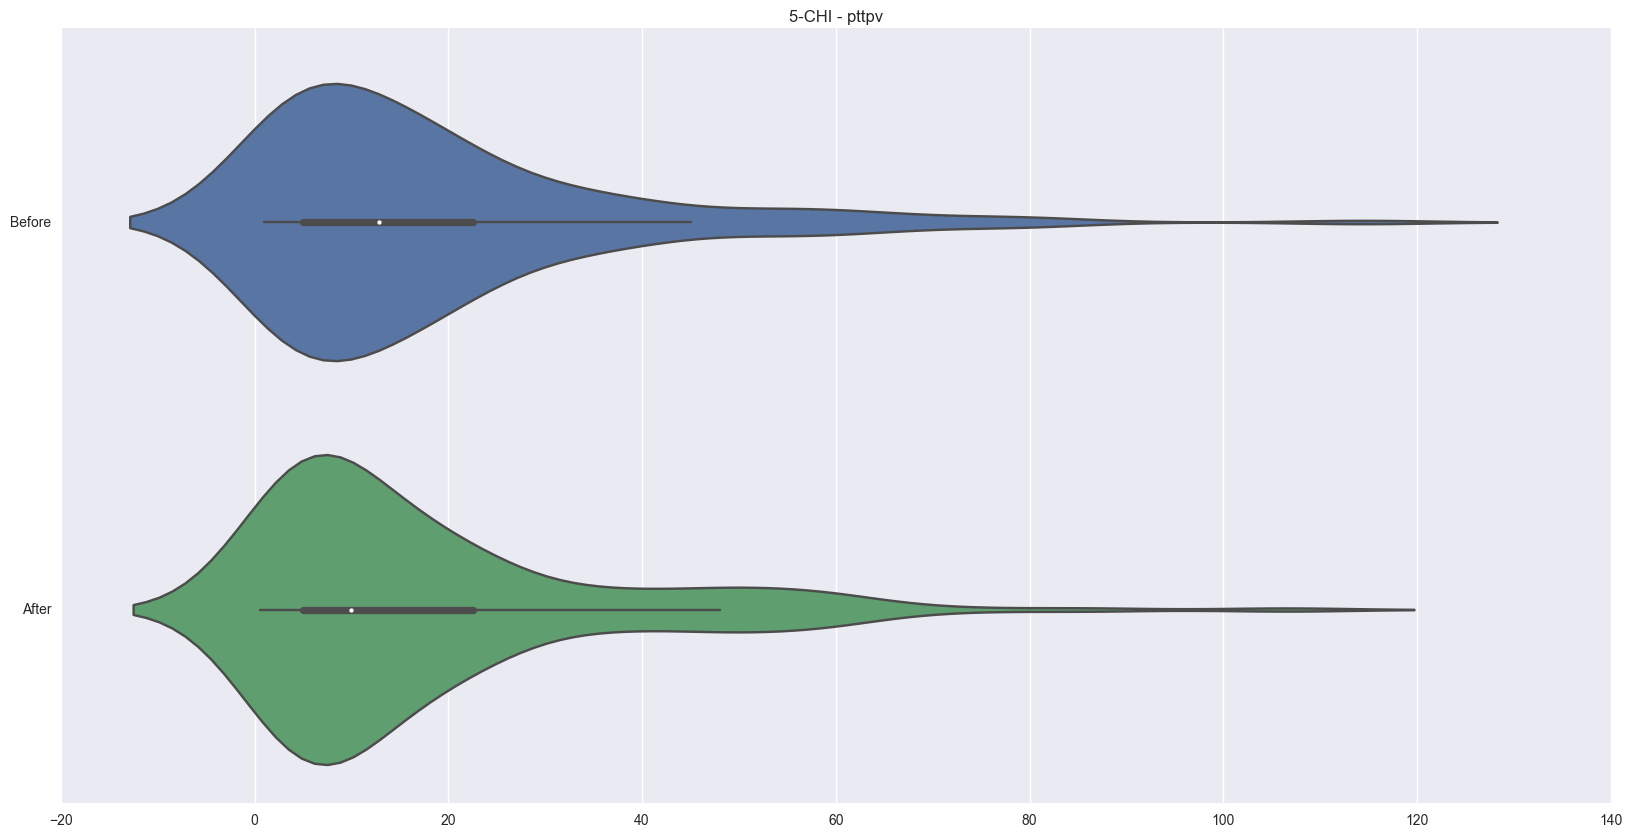

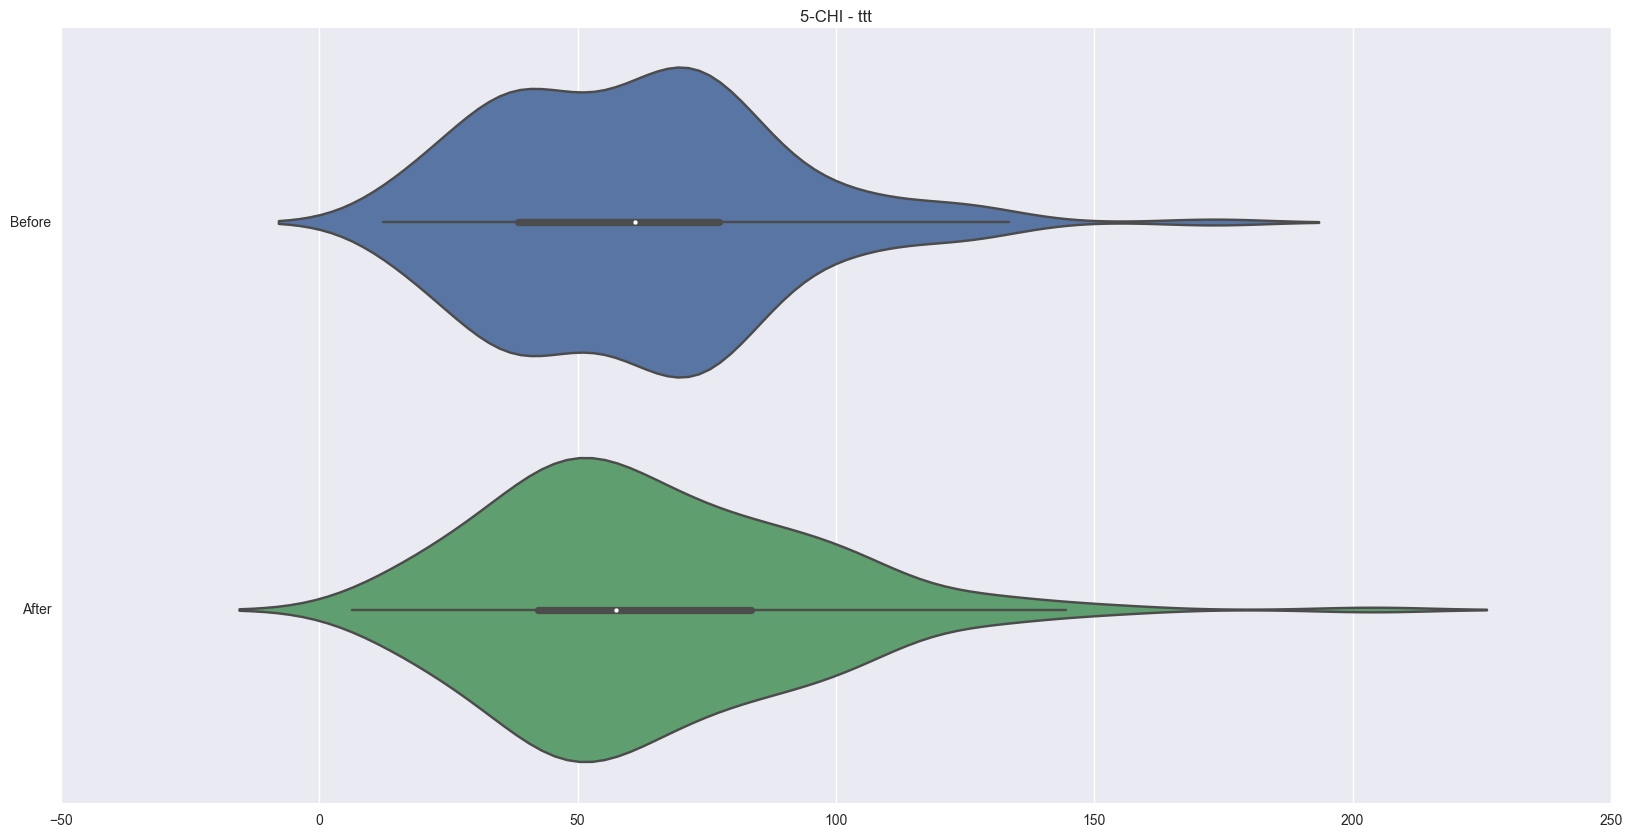

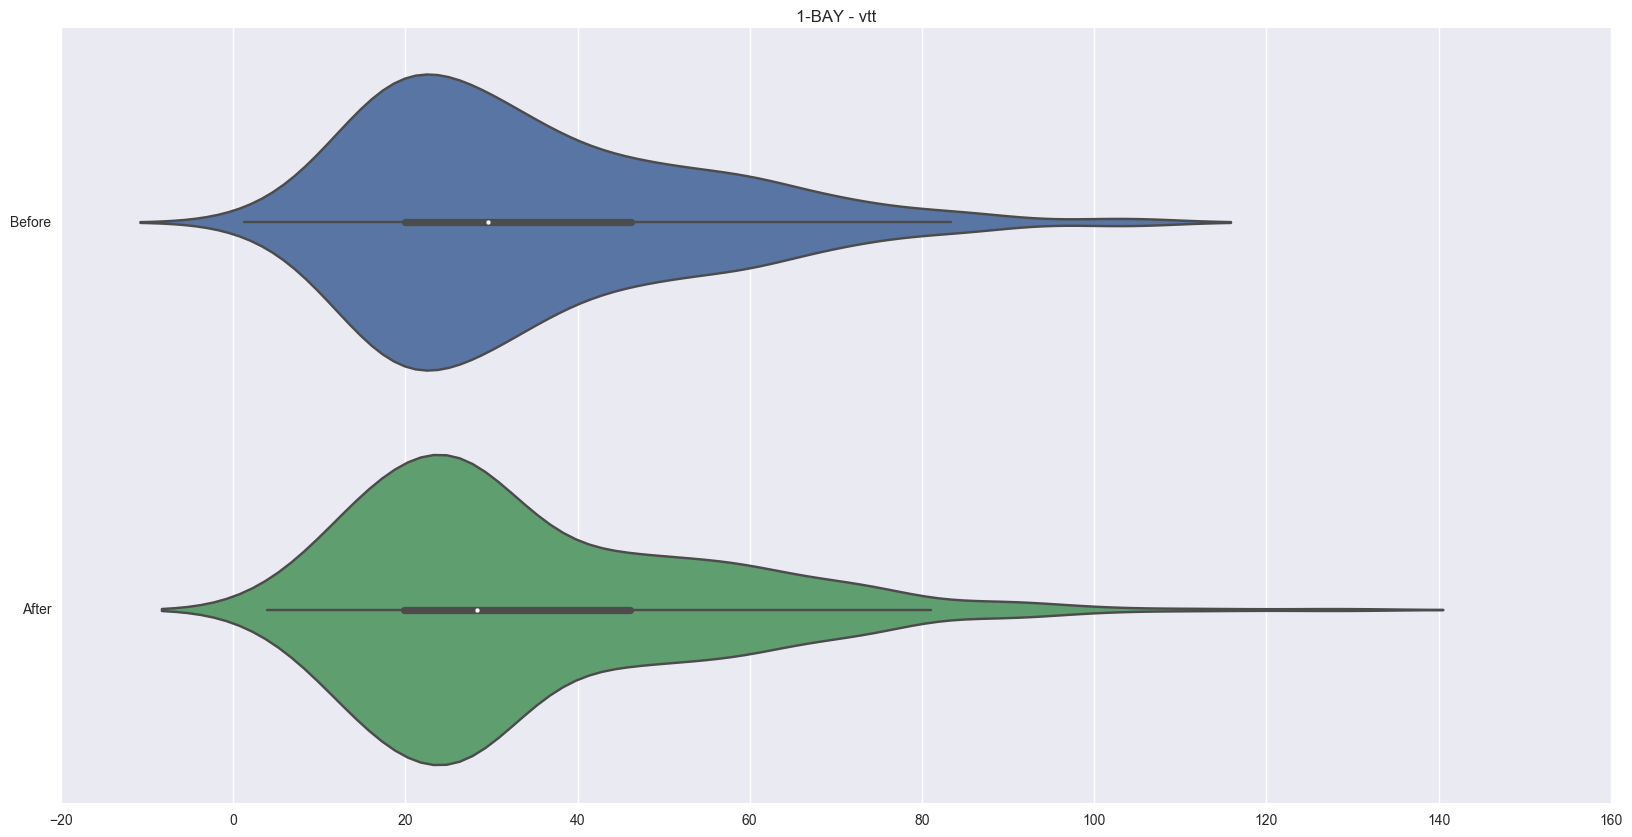

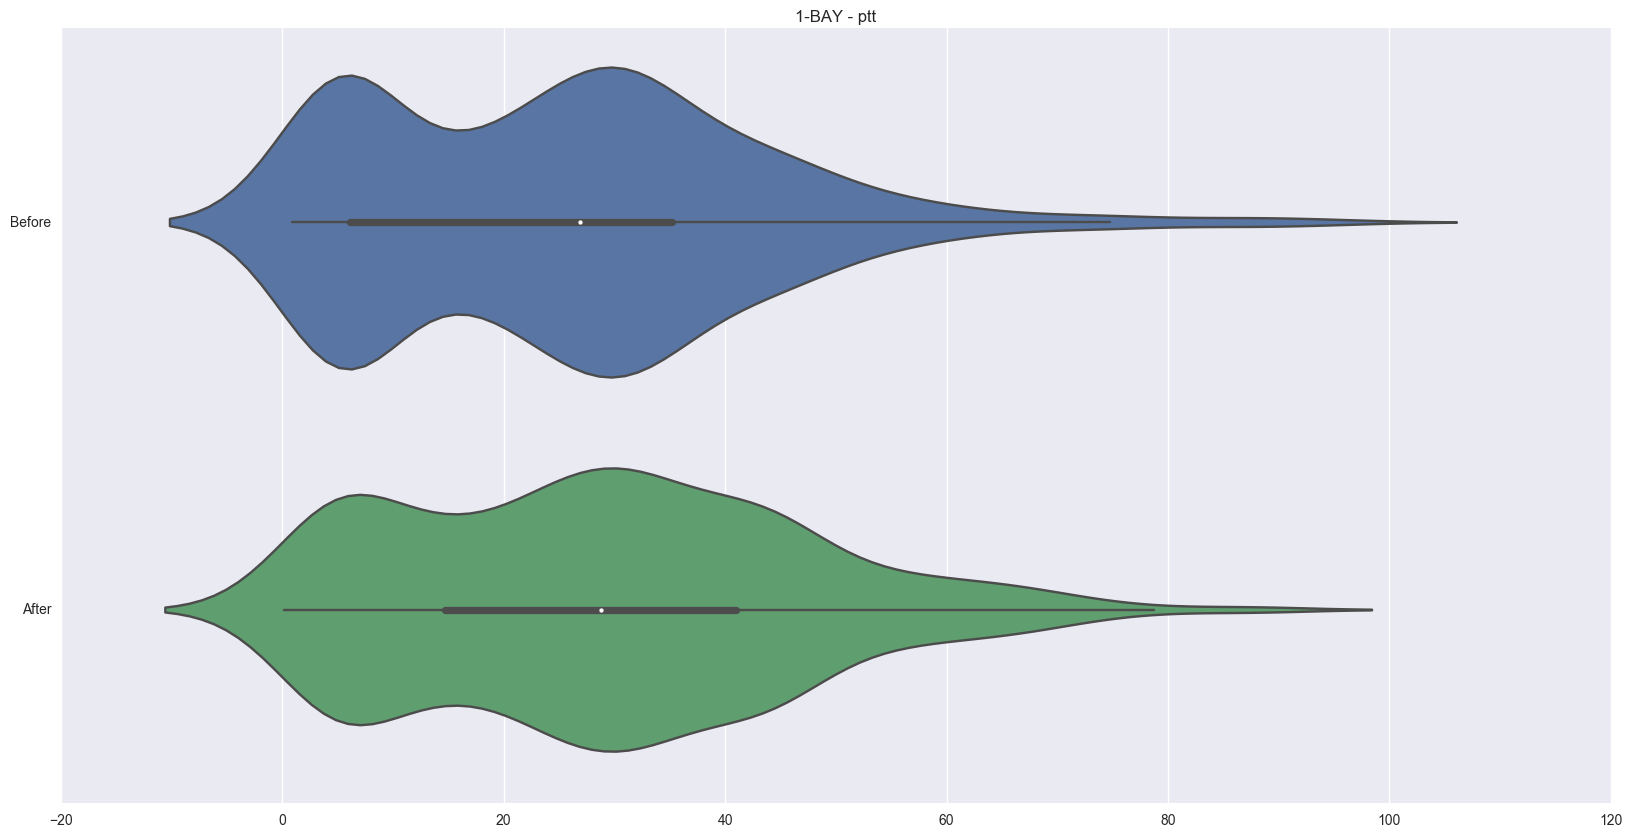

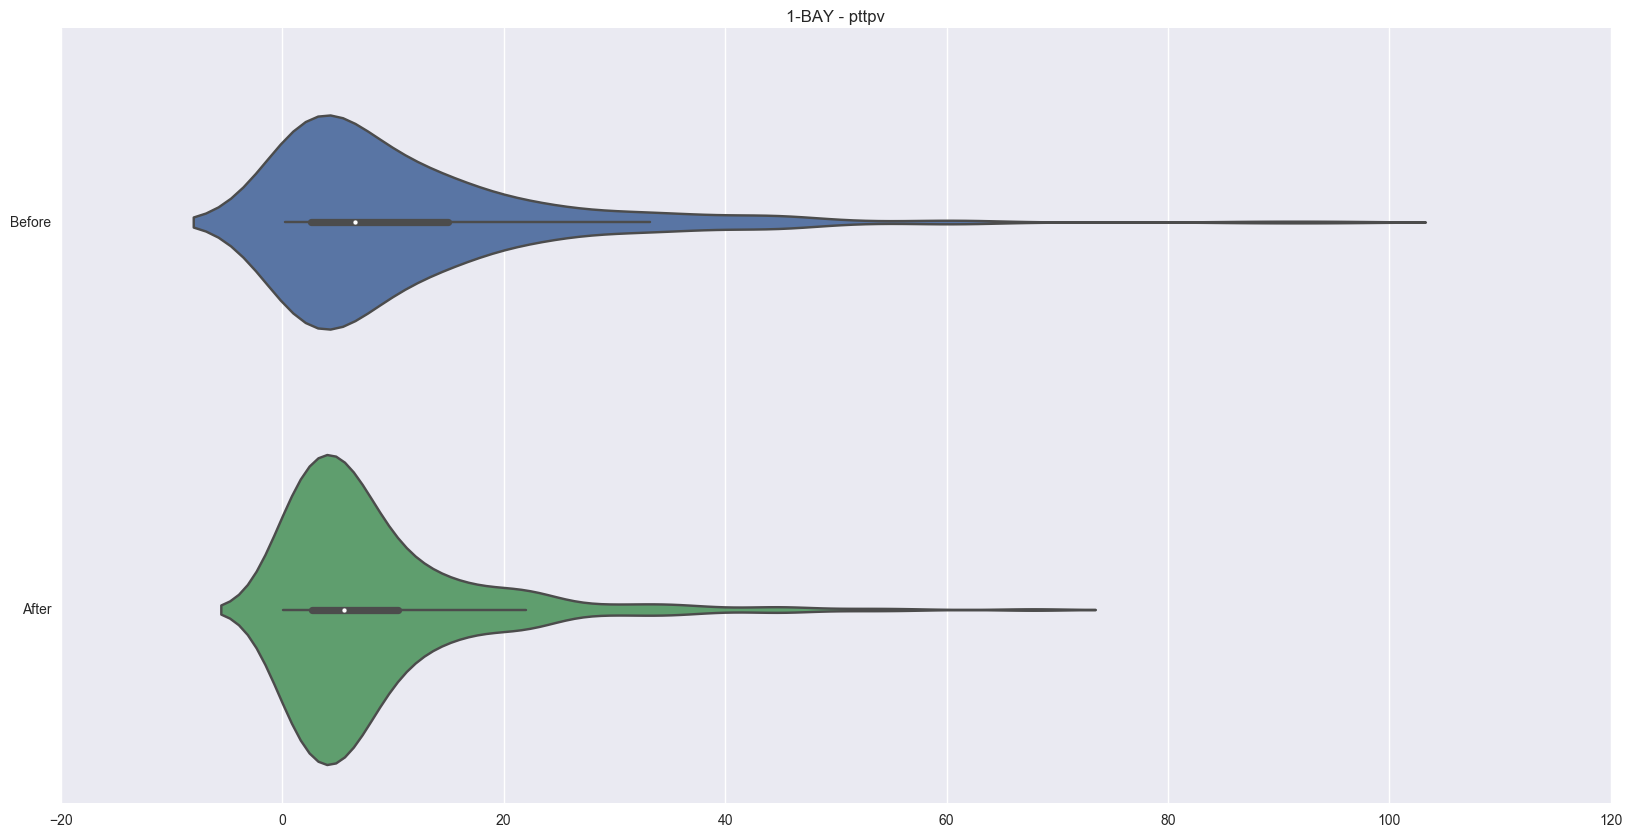

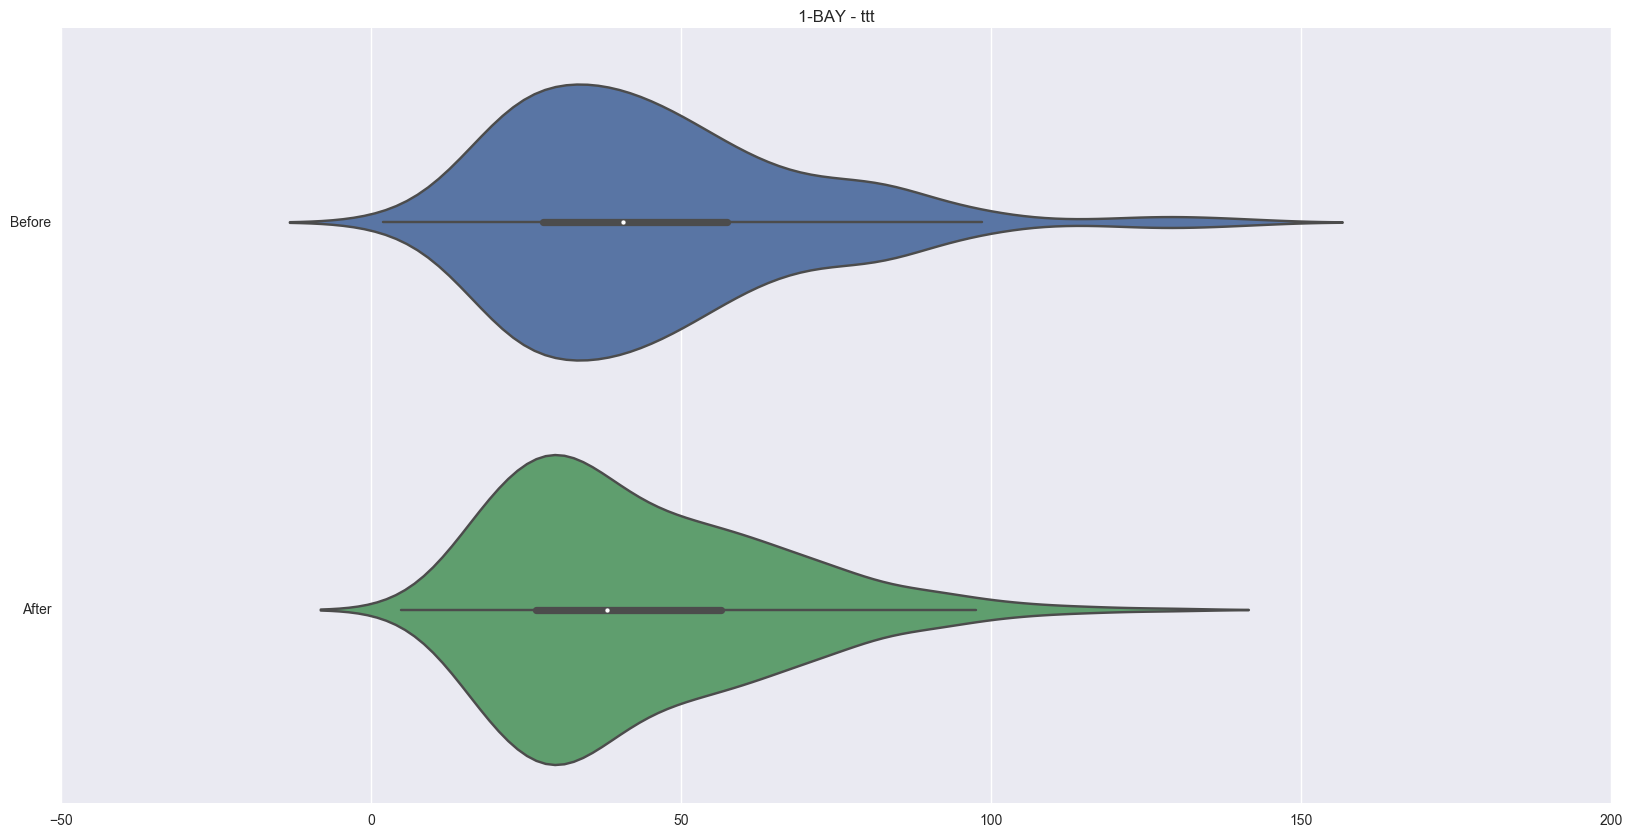

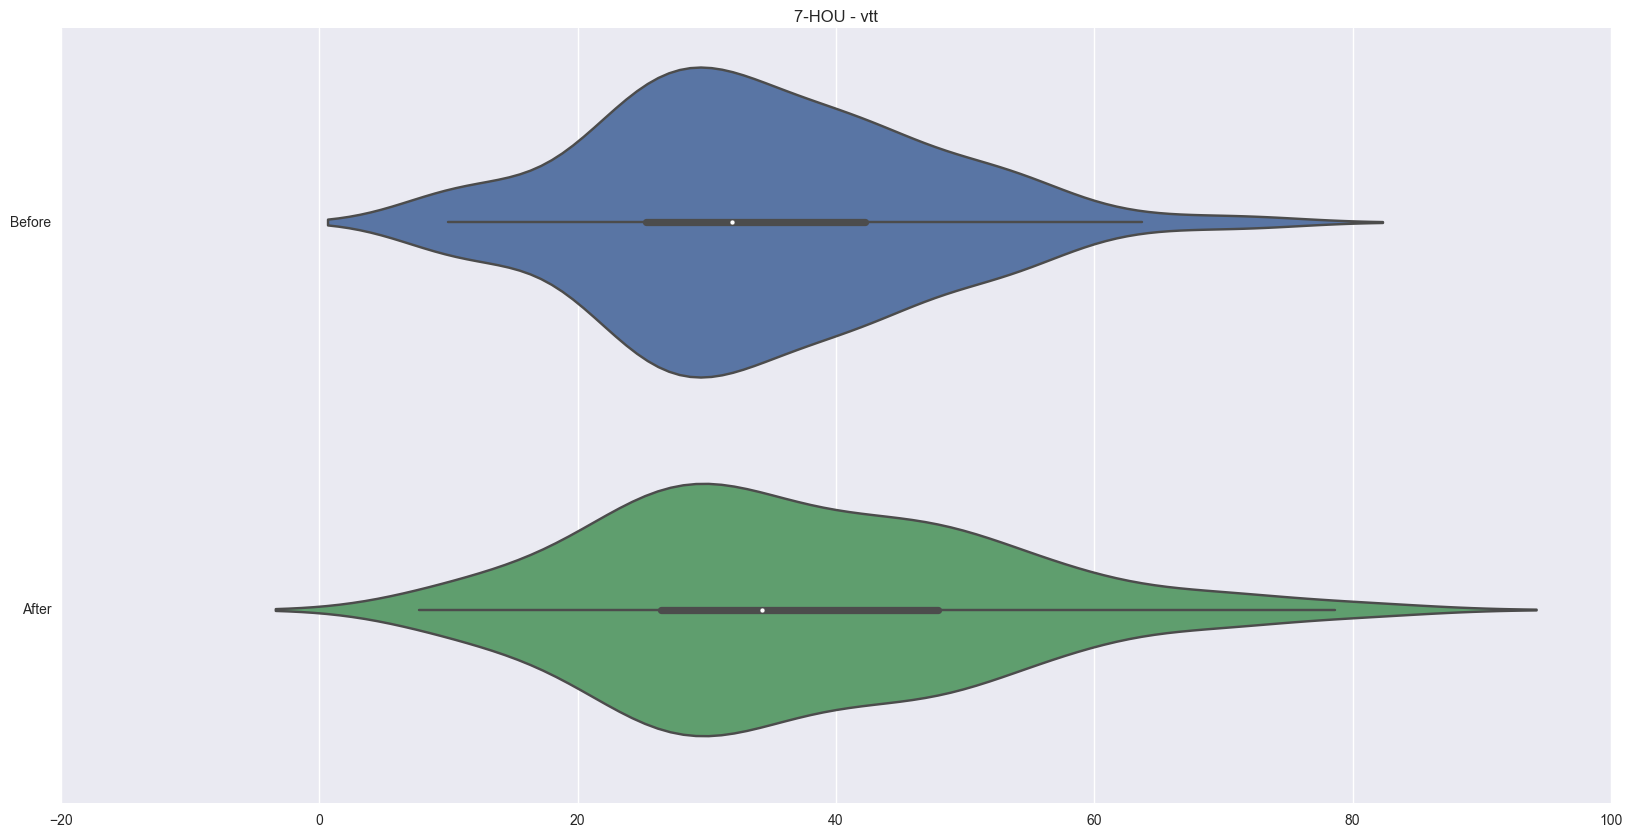

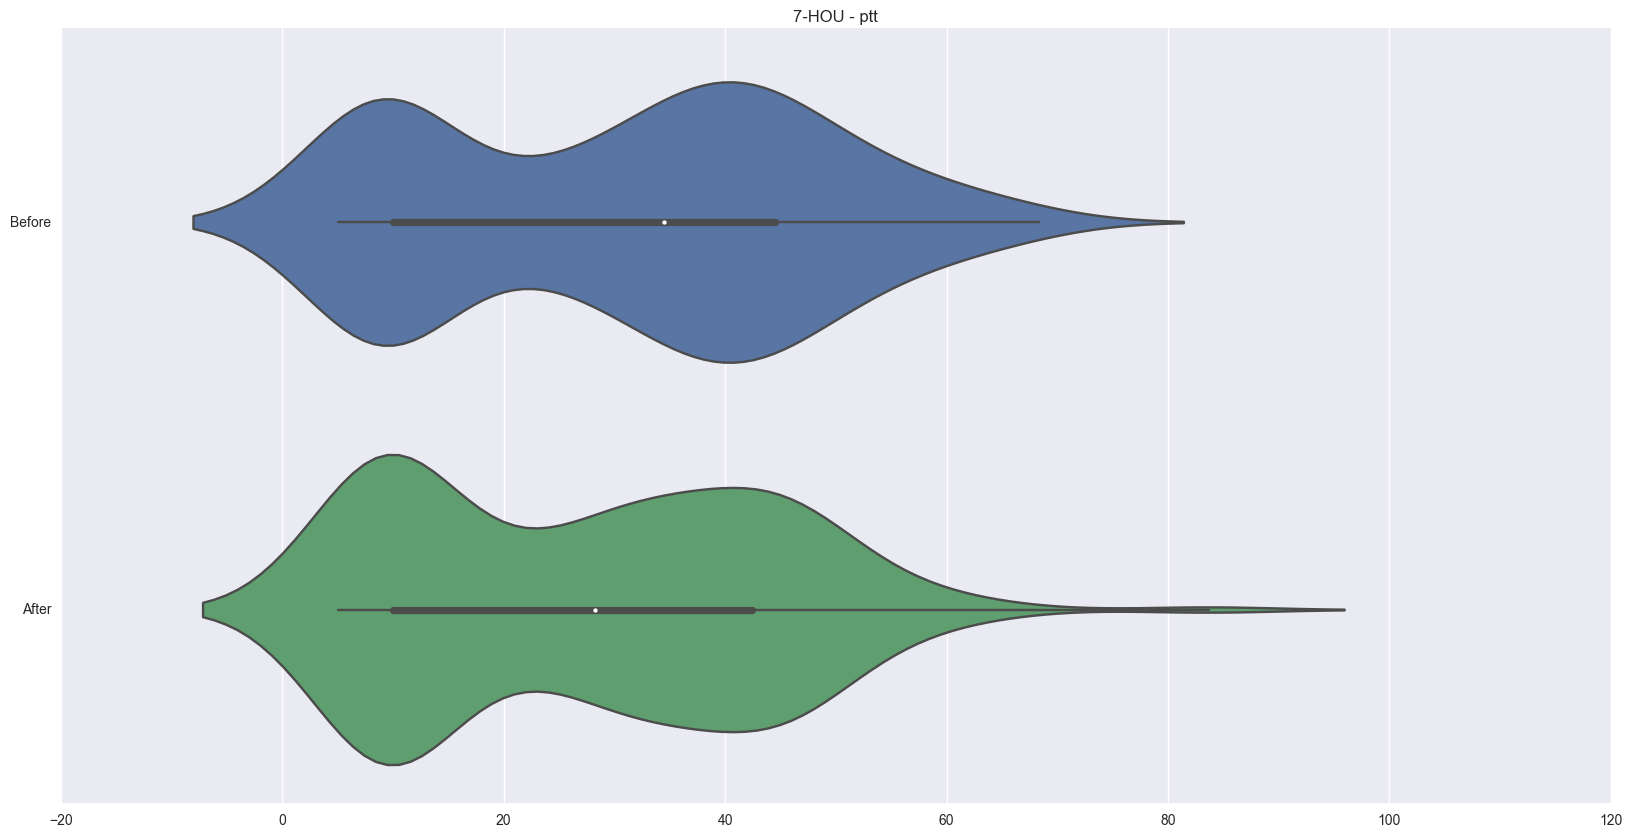

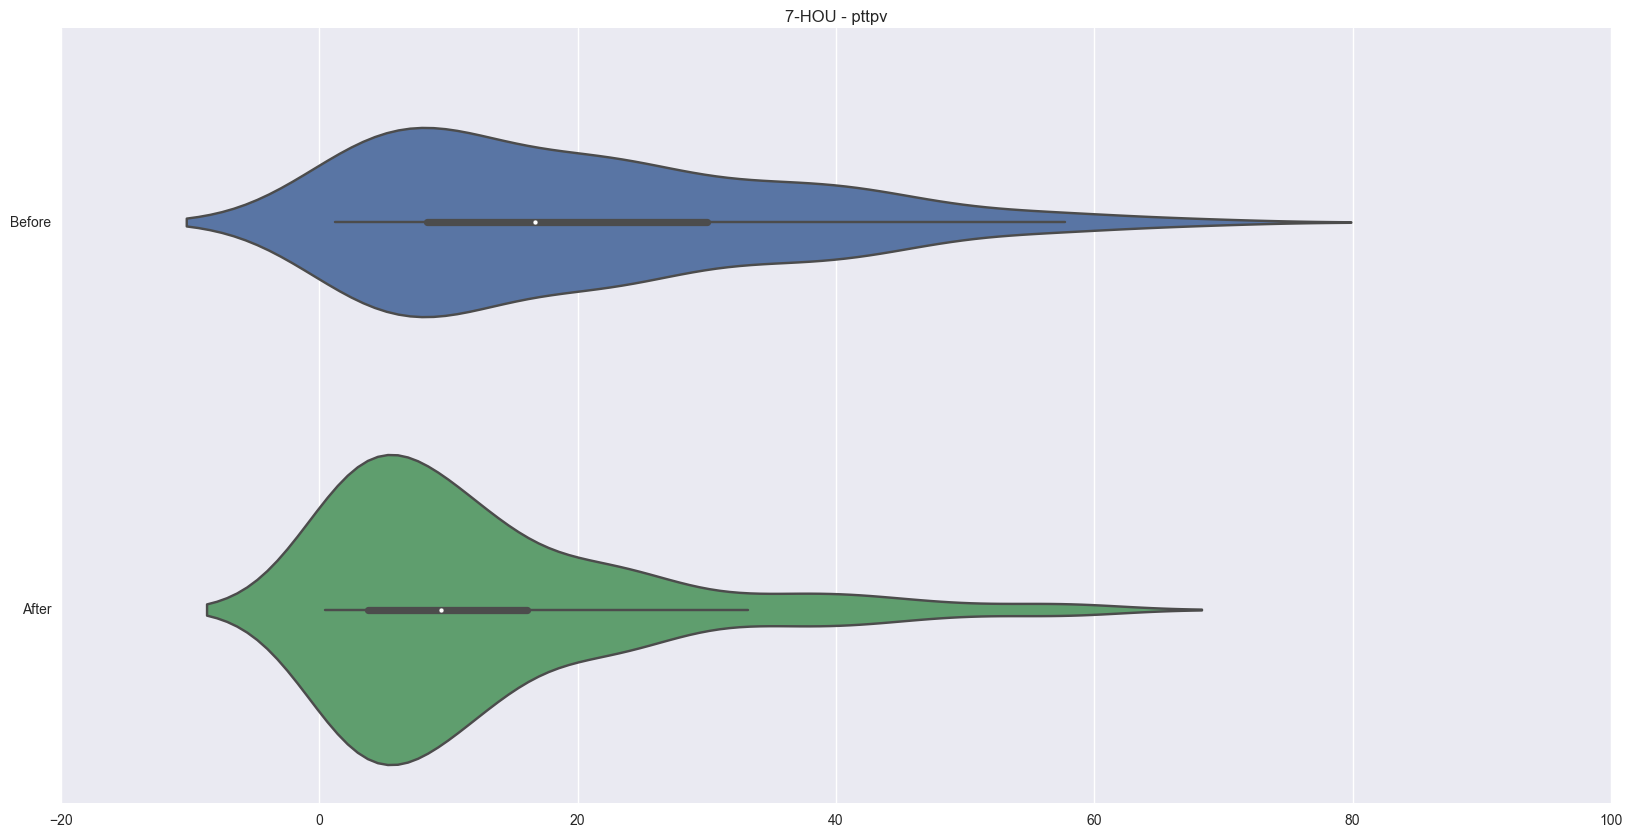

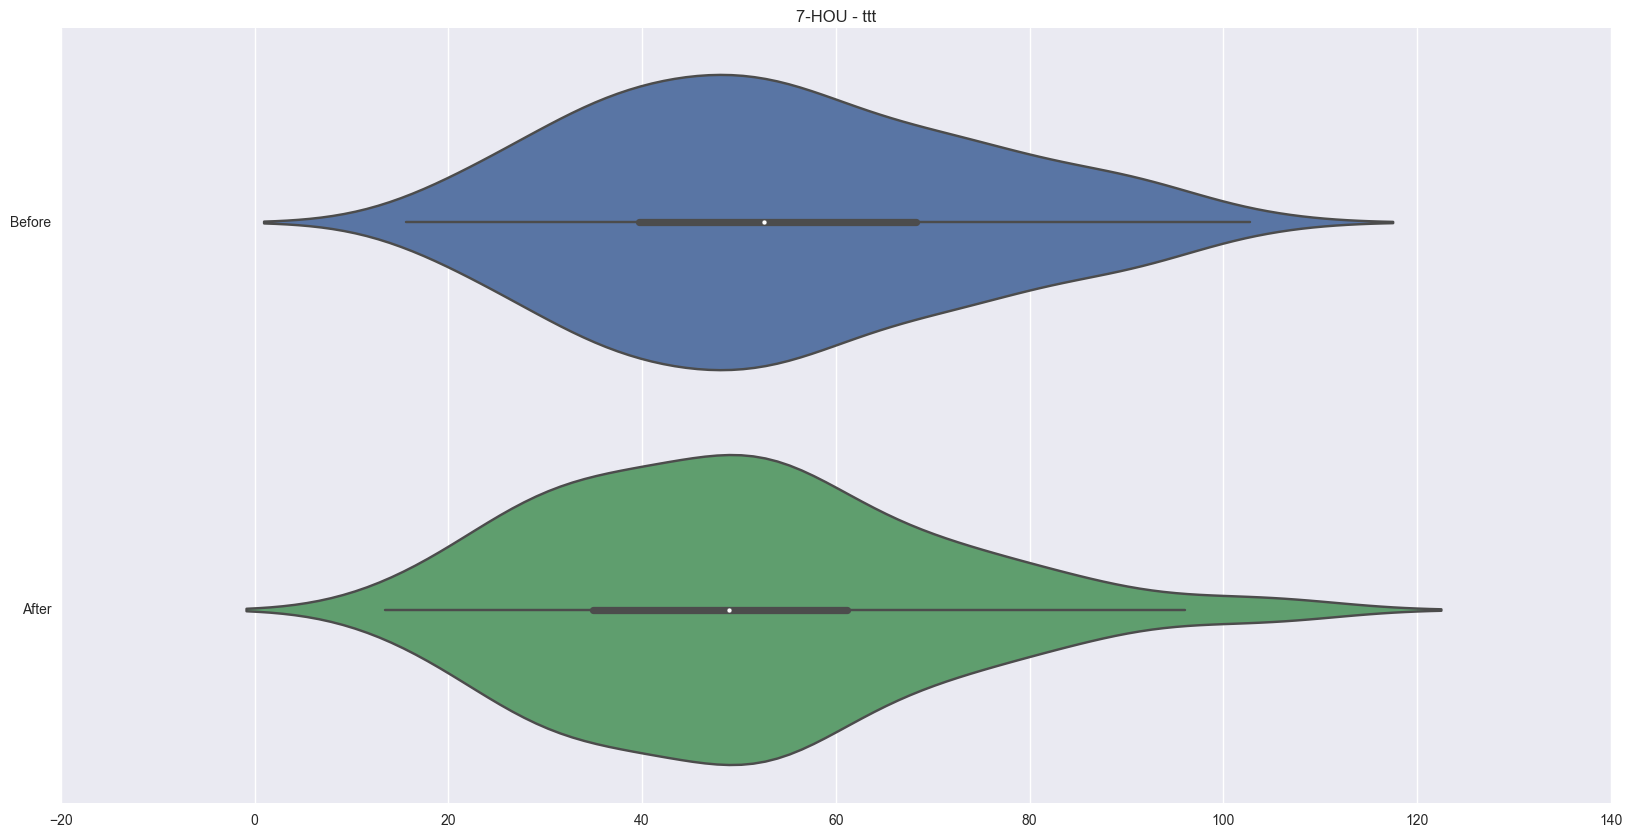

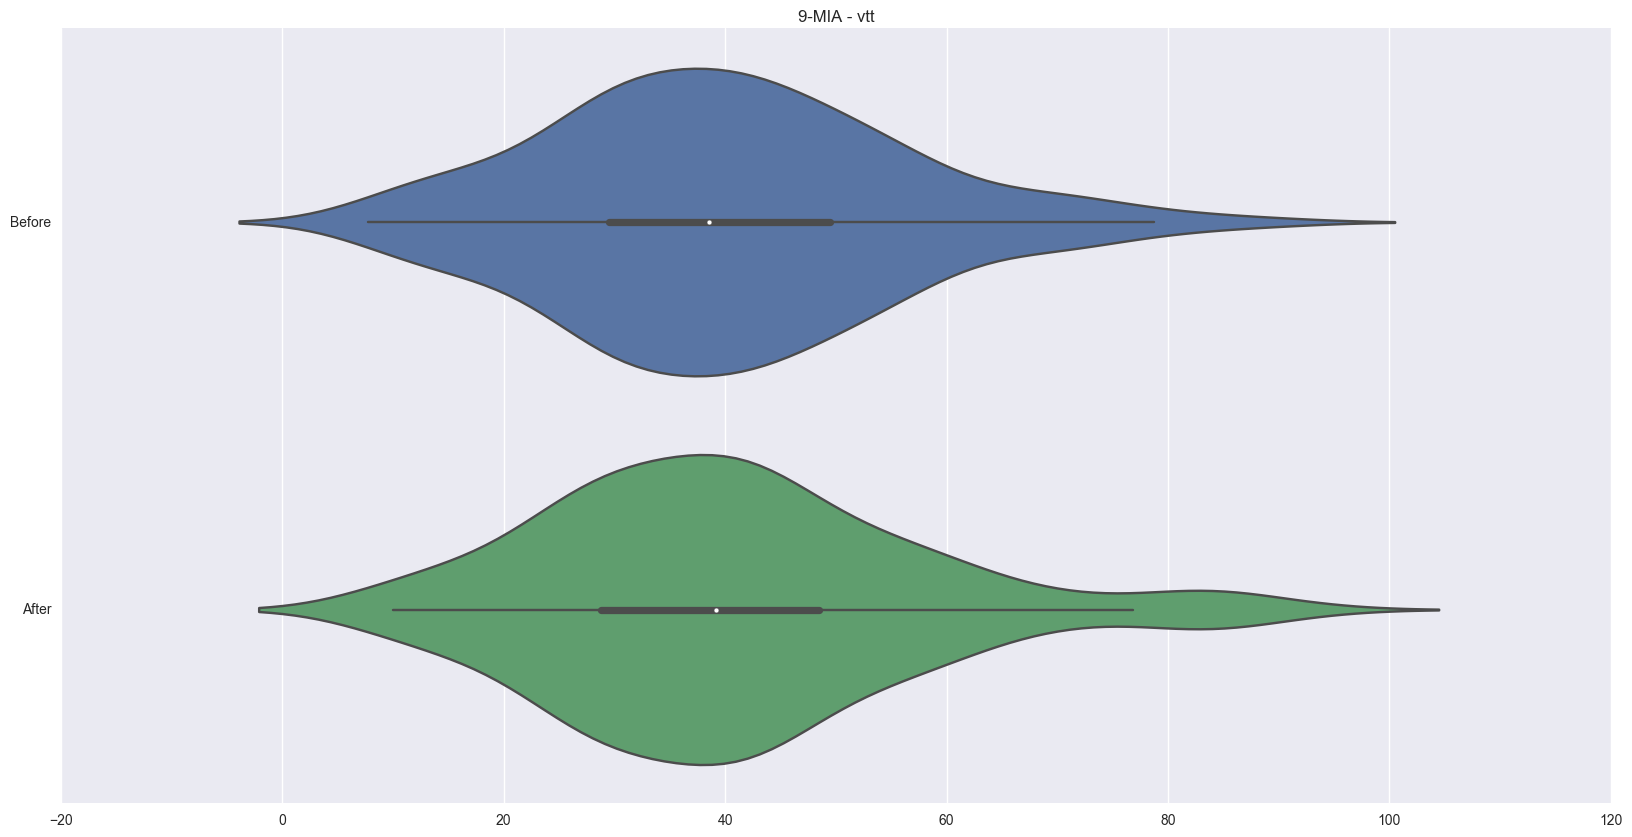

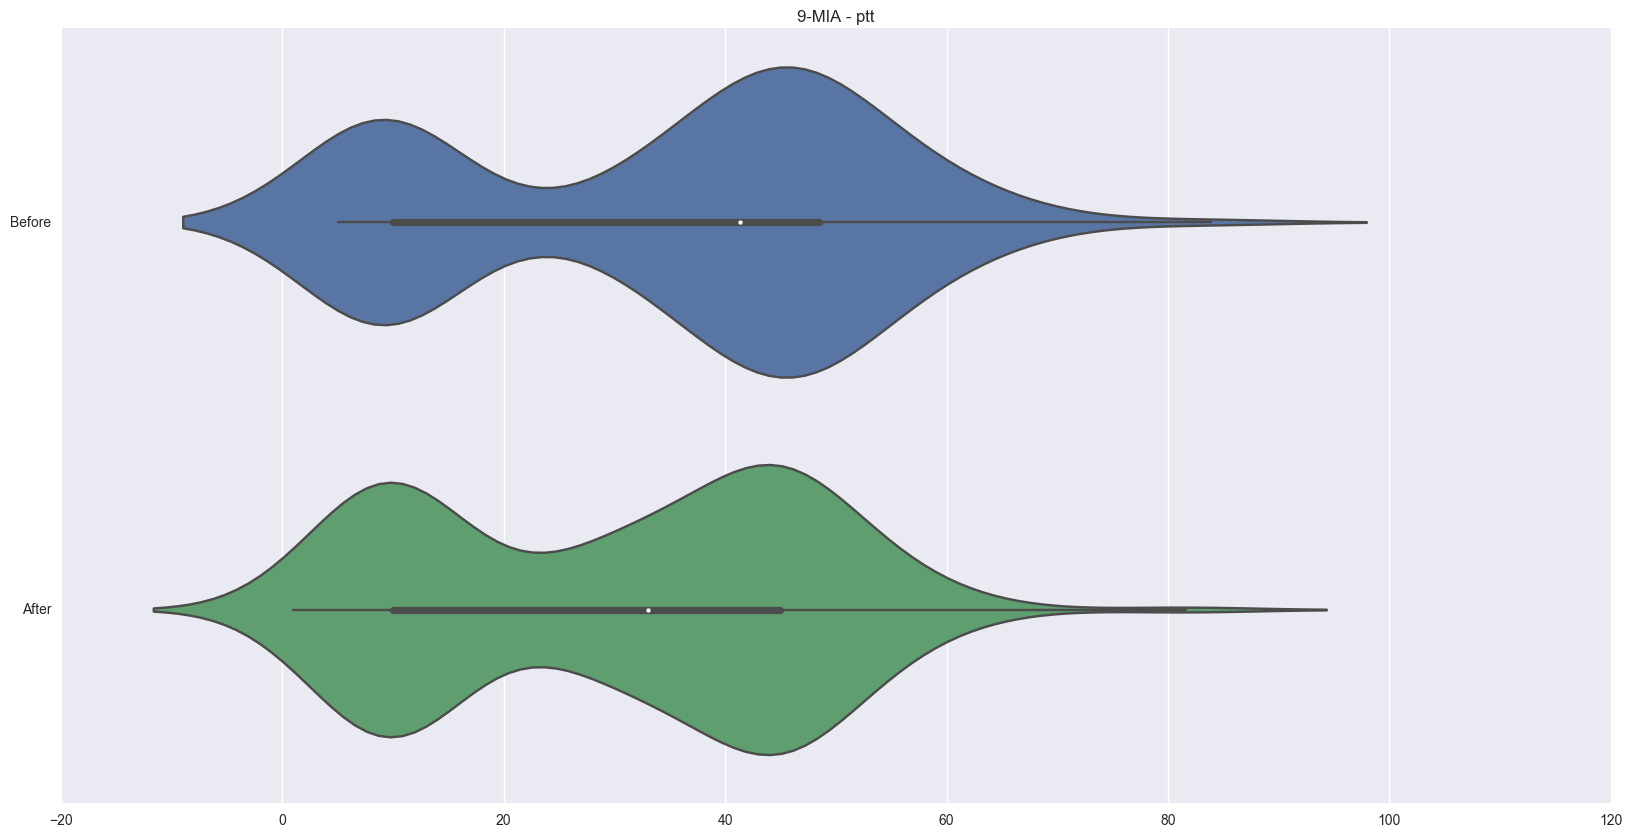

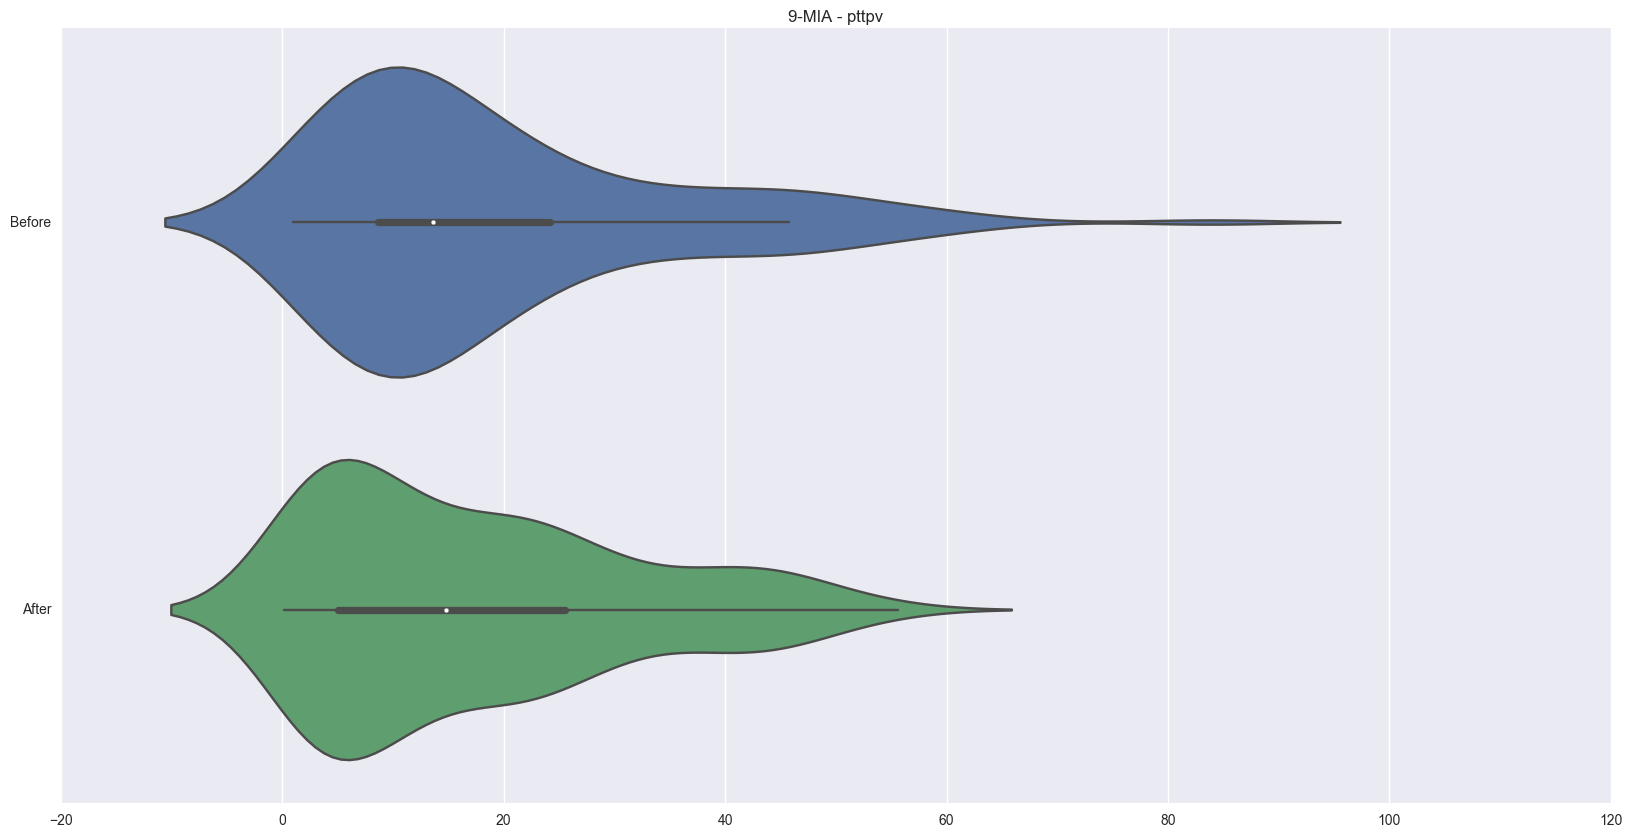

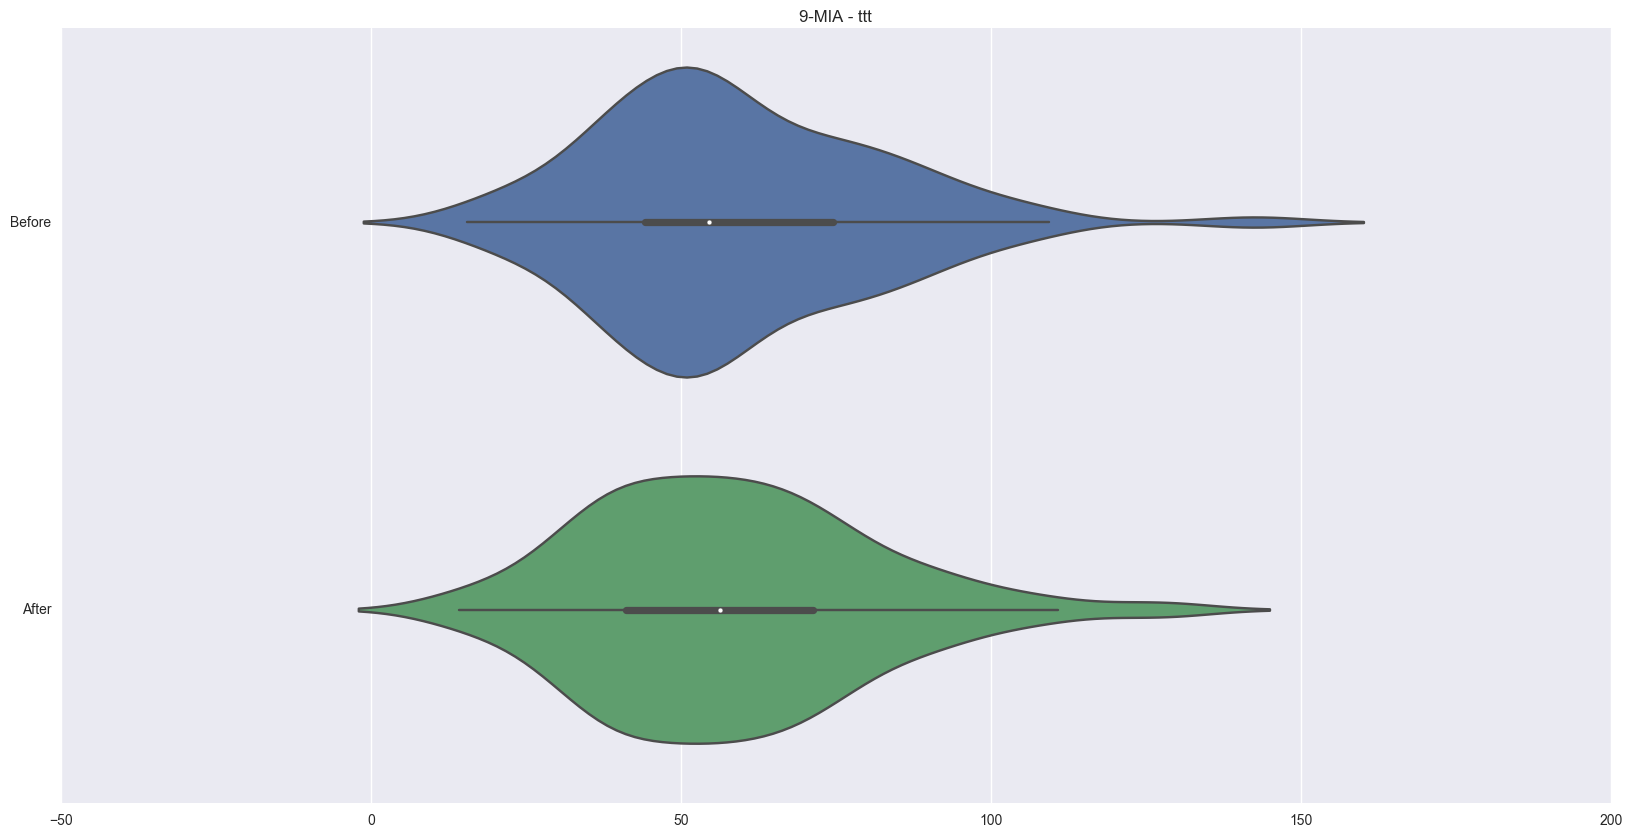

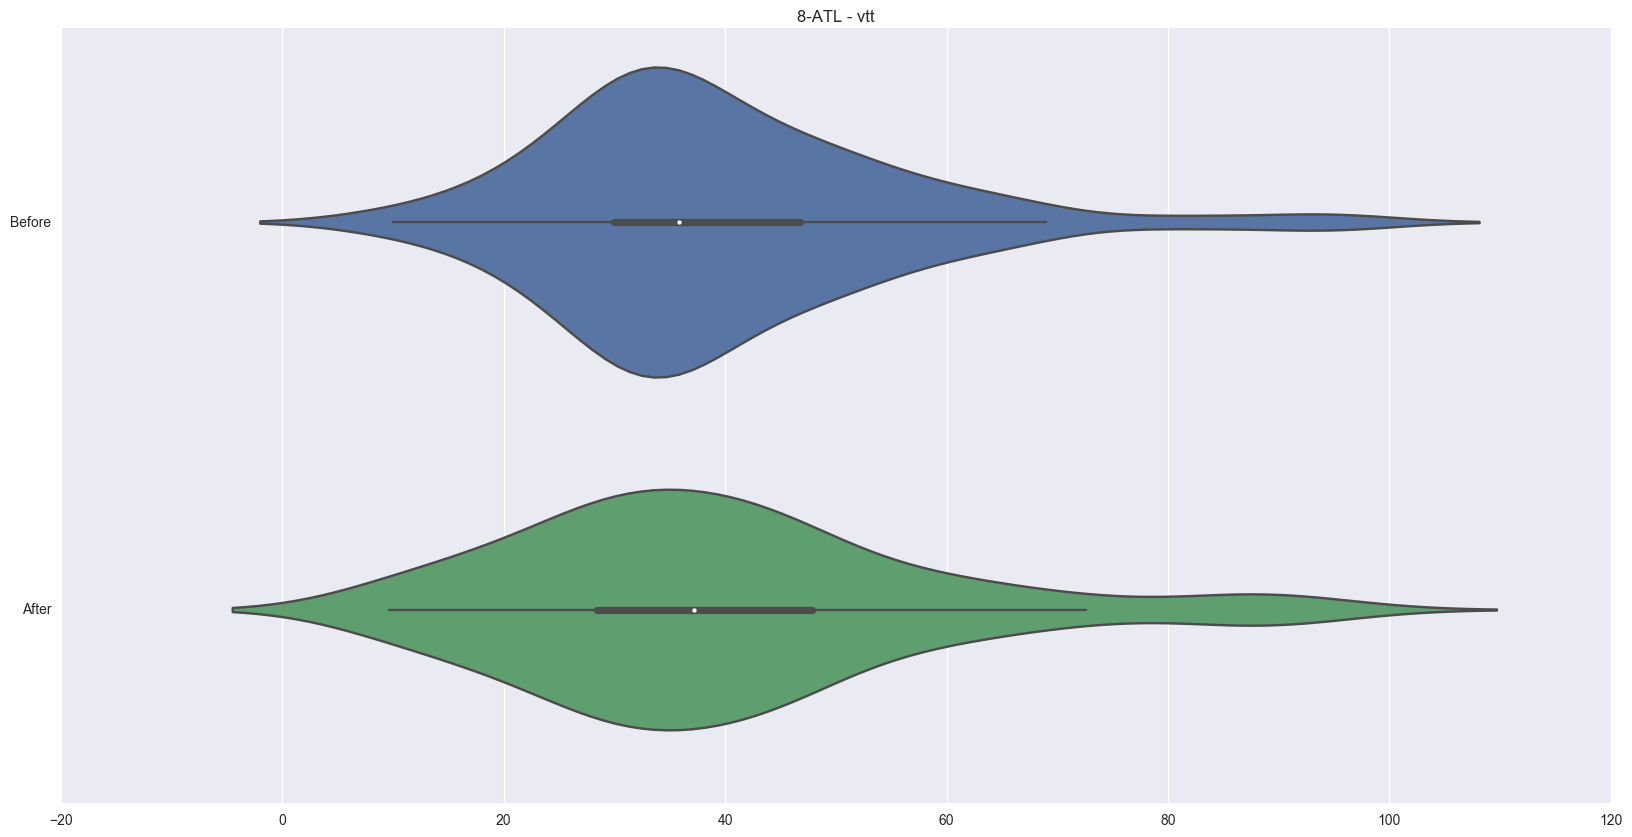

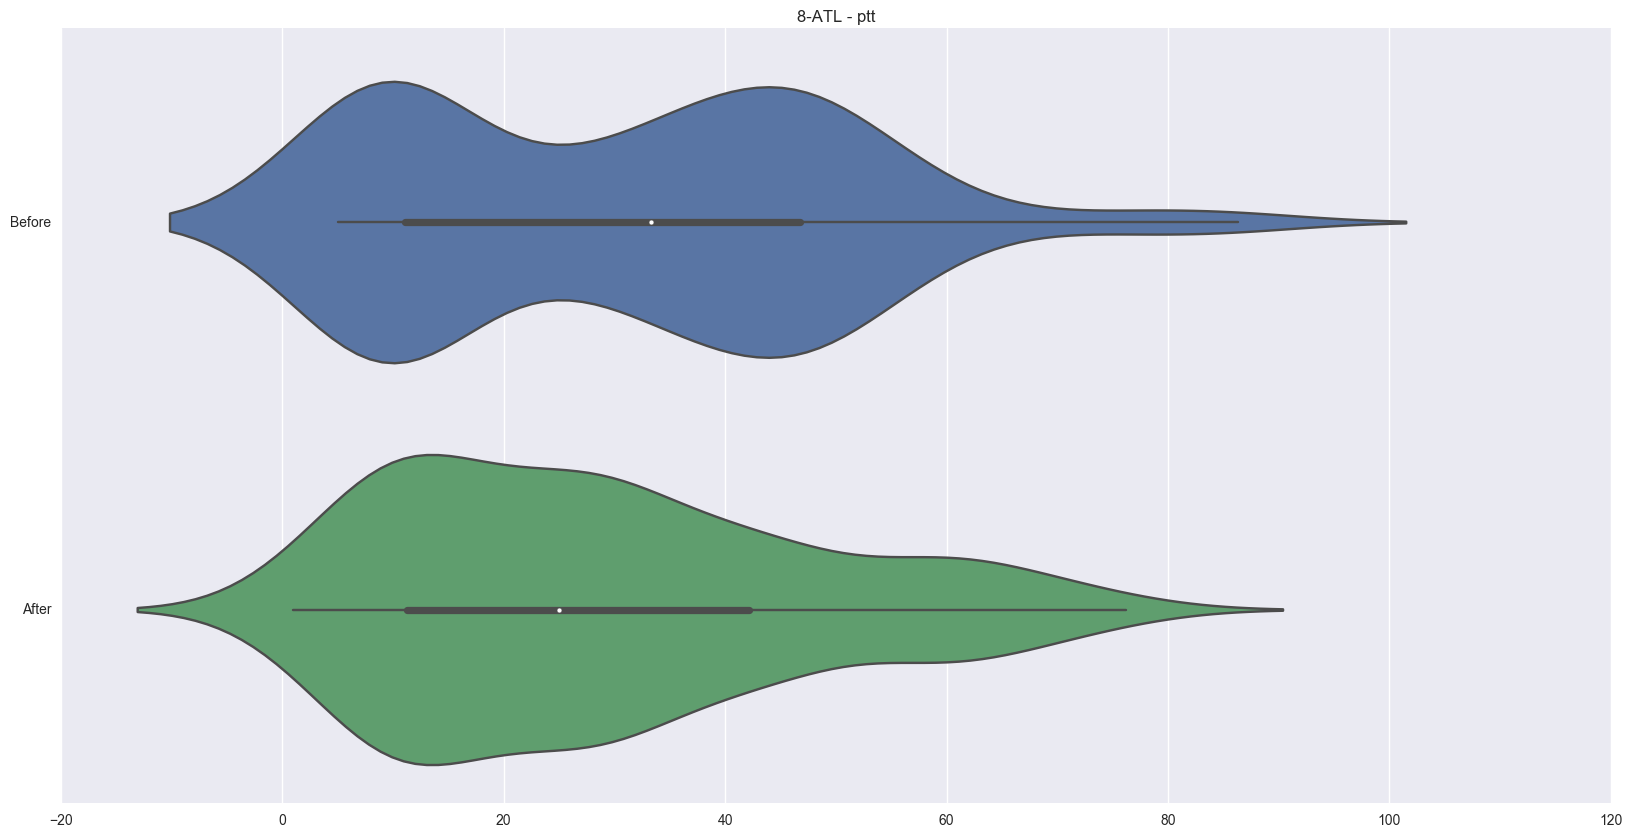

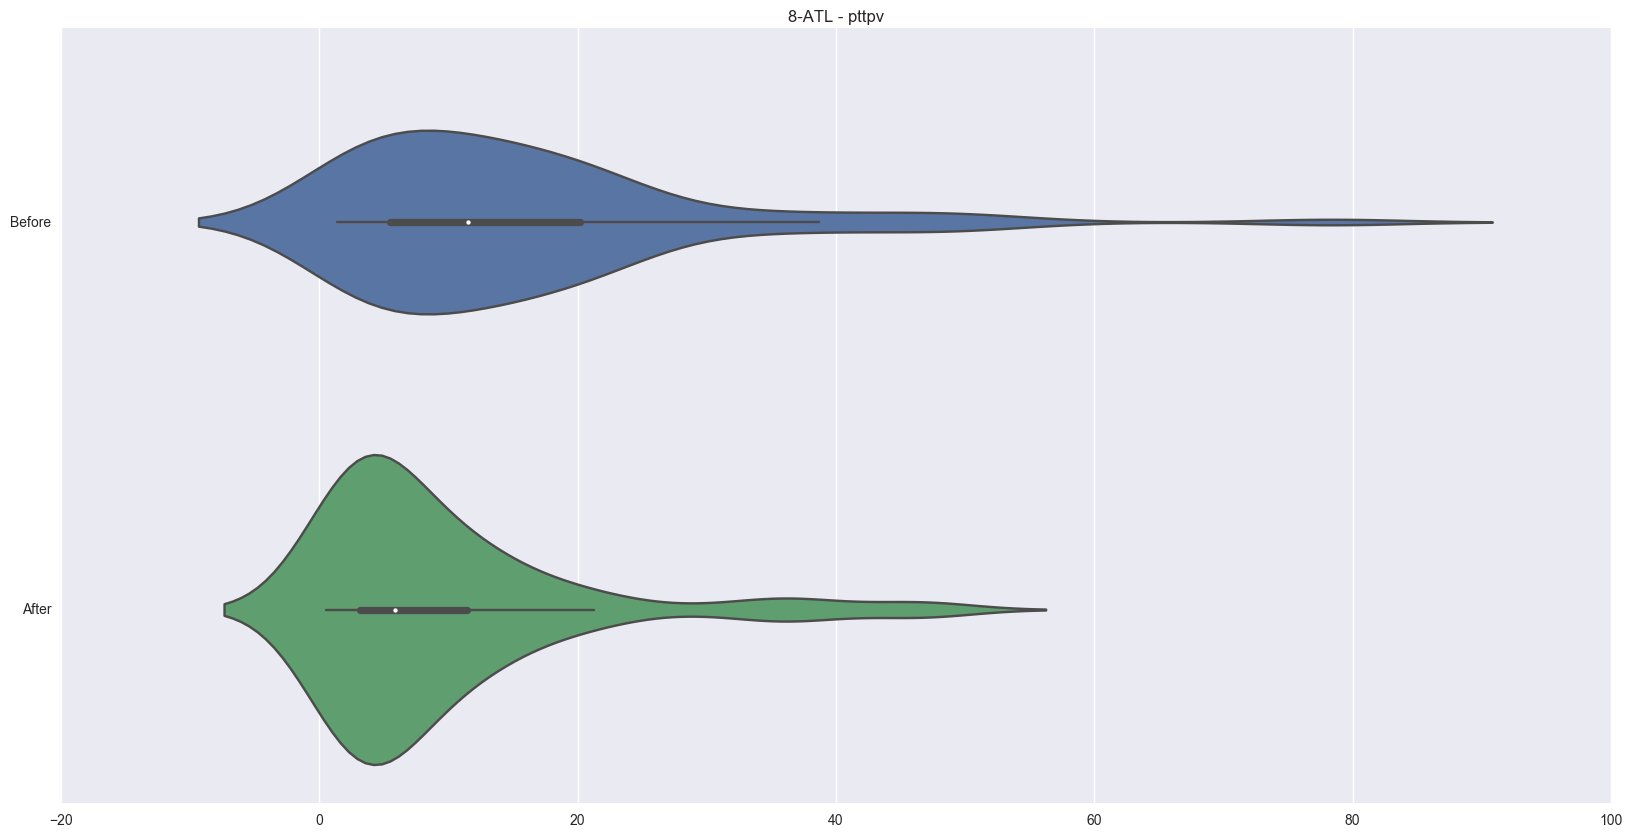

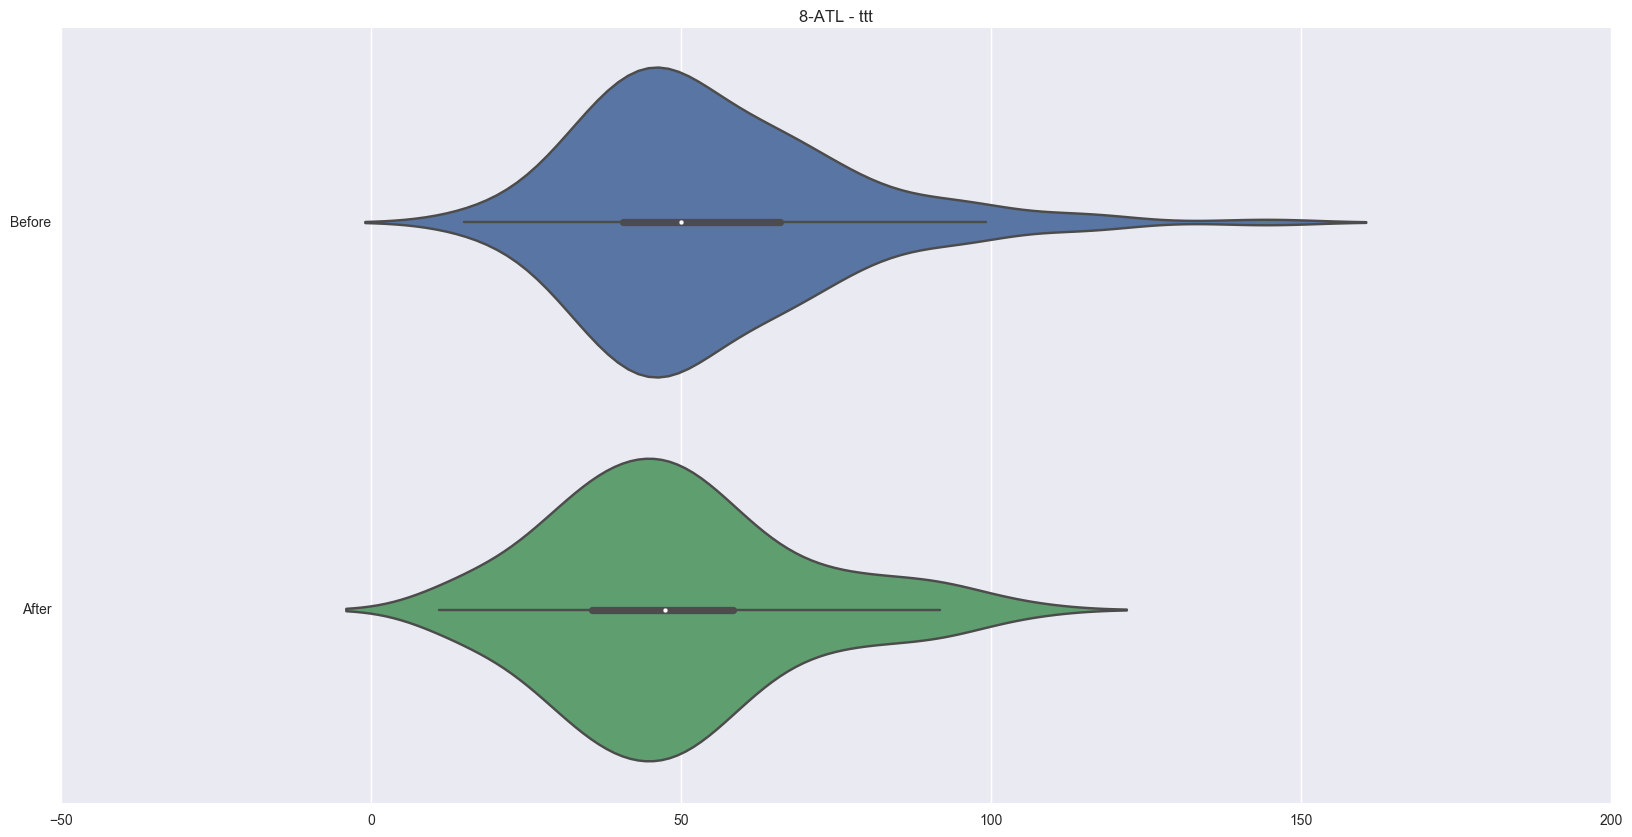

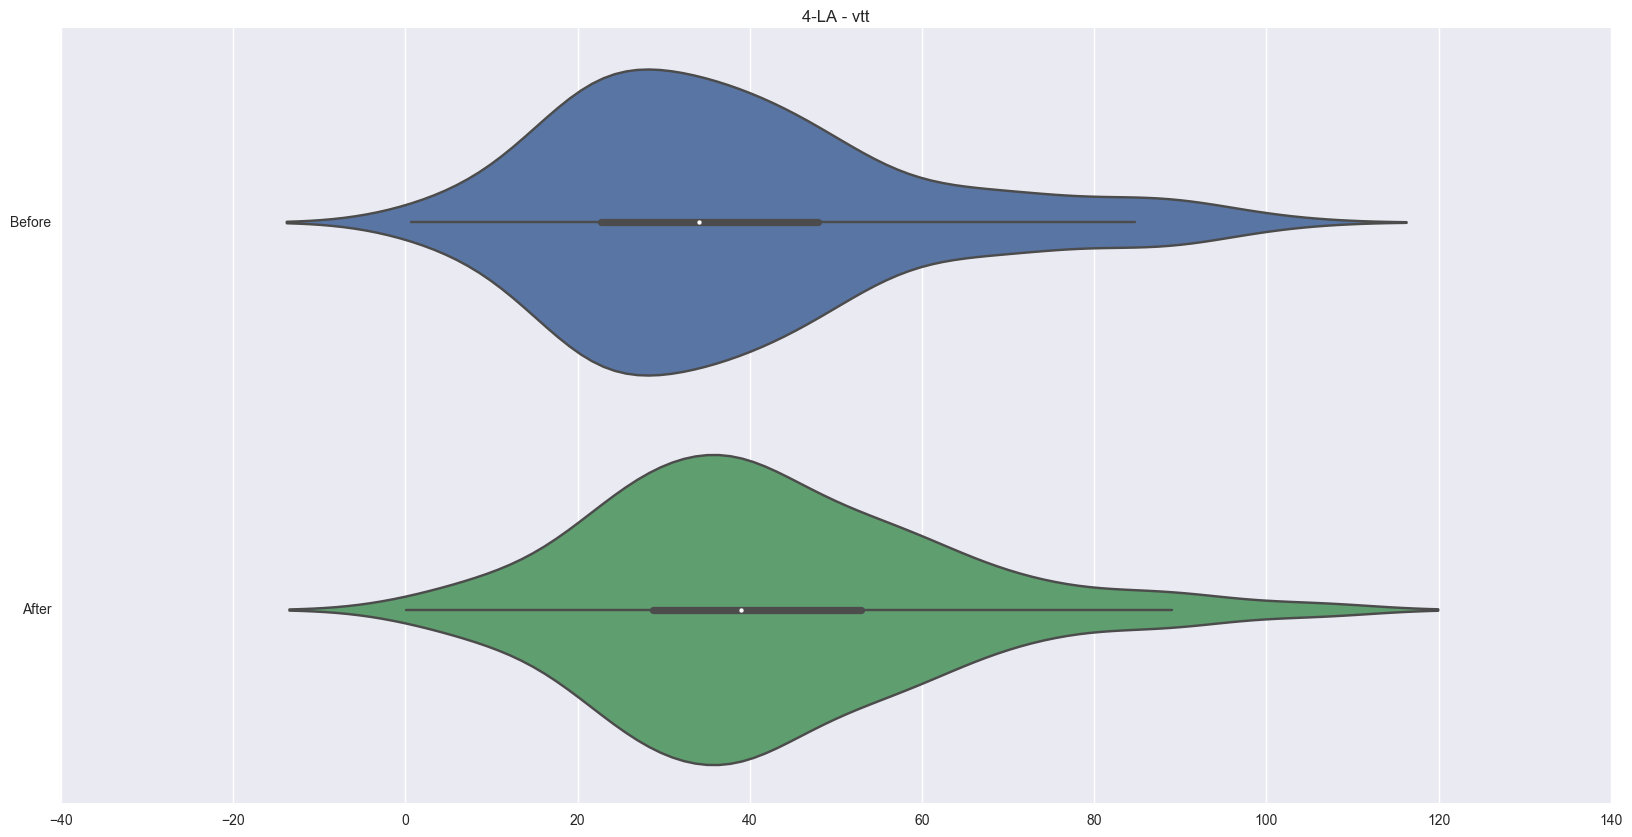

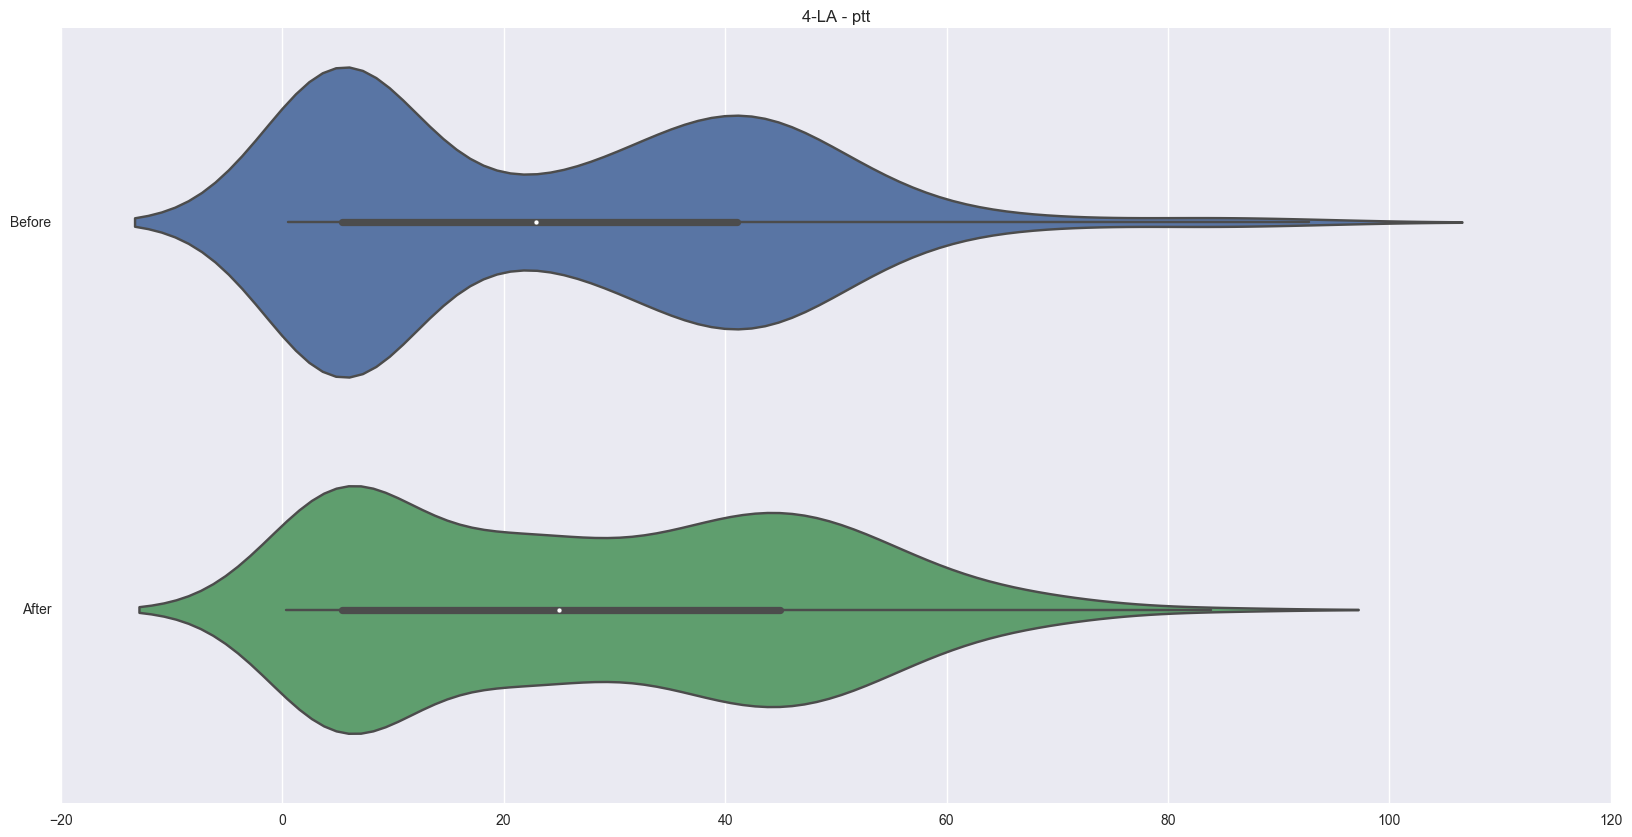

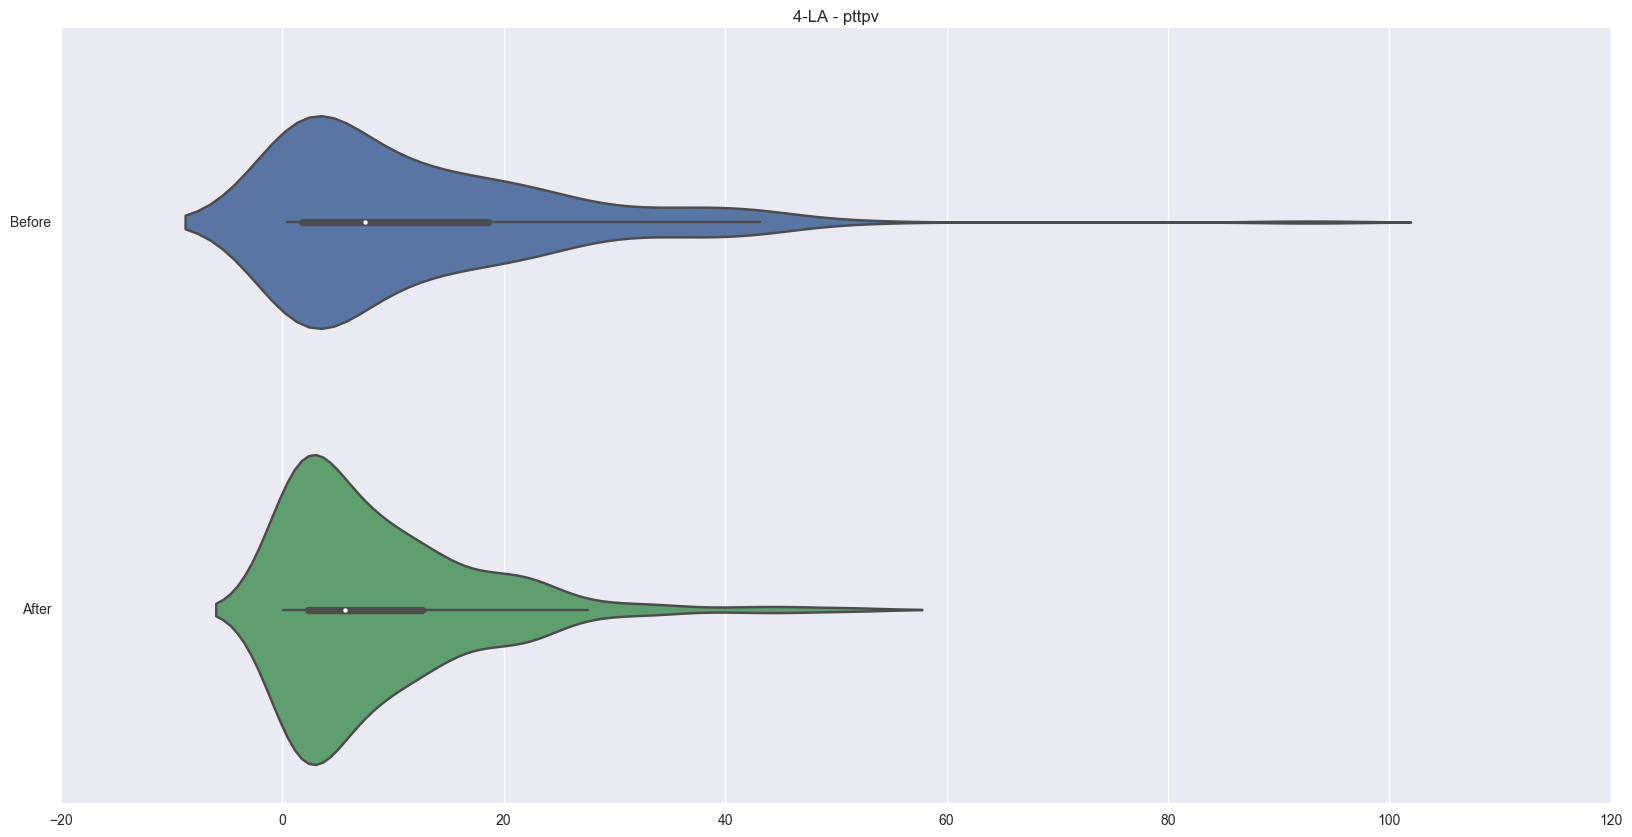

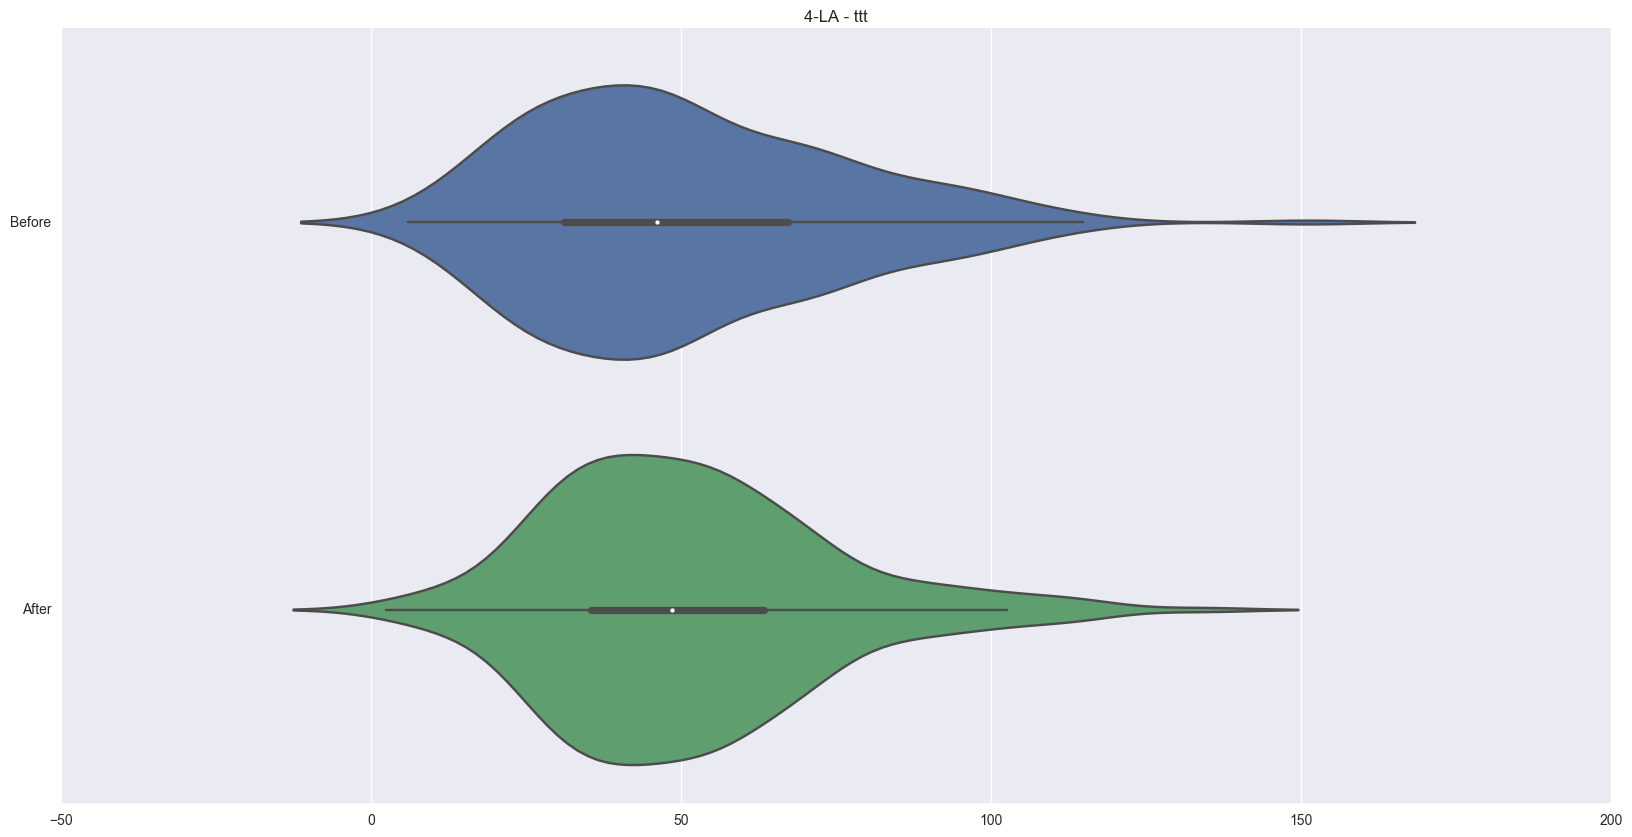

In [87]:
for market in location_dfs:
    for metric in ['vtt', 'ptt', 'pttpv', 'ttt']:
        data = [location_dfs[market]['before'][metric], location_dfs[market]['after'][metric]]
        plt.figure(figsize=(20,10))
        sns.violinplot(data=data, orient='h')
        plt.yticks([0, 1], ['Before', 'After'])
        plt.title(market+' - '+metric)
        plt.show()

#### Statistics

In [94]:
# market, metric, before_mu, after_mu, t, p_t, F, p_F, df
summary_table = []

for market in location_dfs:
    for metric in ['vtt', 'ptt', 'pttpv', 'ttt']:
        
        summary_row = [market, metric]
        
        before = location_dfs[market]['before'][metric]
        after = location_dfs[market]['after'][metric]
    
        # calculate summary stats

        before_summary = np.mean(before)
        after_summary = np.mean(after)
        
        mu_stats = ttest_ind(before, after, usevar='unequal')

        sigma_stats = levene(before, after)
        
        all_values = [before_summary, after_summary] + map(float, mu_stats) + map(float, sigma_stats)

        summary_row += all_values
    
        summary_table.append(summary_row)

In [96]:
sum_cols = ['market', 'metric', 'before_mean', 'after_mean', 't-score', 'p_t', 'df', 'F', 'p_F']
summary = pd.DataFrame(summary_table, columns=sum_cols)

summary.head()

,market,metric,before_mean,after_mean,t-score,p_t,df,F,p_F
0,2-NY,vtt,32.329454,29.327321,1.775971,0.076779,291.957970,0.160032,0.689420
1,2-NY,ptt,25.602914,23.009597,1.277377,0.202494,288.955015,0.757123,0.384945
2,2-NY,pttpv,15.360505,11.775642,2.232852,0.026330,286.922345,3.684703,0.055888
3,2-NY,ttt,47.689959,41.102963,2.738837,0.006547,290.316460,0.204061,0.651798
4,6-DAL,vtt,32.811537,39.206834,-4.644028,0.000005,433.121039,7.146558,0.007777


In [97]:
summary.to_csv('Pickup_Logic_Impact.csv', index=False)

In [93]:
# finally close the connection
conn.close()